# Исследование объявлений о продаже квартир

Предоставлены данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Есть цель - научиться определять рыночную стоимость объектов недвижимости. Необходимо провести исследование на зависимость цены квартир от многих факторов, чтобы в дальнейшем построить автоматизированную систему, которая будет отследивать аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных.

<font size=+1><b>Данные:</b></font><br>
Данные с объявлениями о продаже недвижимости real_estate_data.csv
- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- `balcony` — число балконов
- `ceiling_height` — высота потолков (м)
- `cityCenters_nearest` — расстояние до центра города (м)
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
- `first_day_exposition` — дата публикации
- `floor` — этаж
- `floors_total` — всего этажей в доме
- `is_apartment` — апартаменты (булев тип)
- `kitchen_area` — площадь кухни в квадратных метрах (м²)
- `last_price` — цена на момент снятия с публикации
- `living_area` — жилая площадь в квадратных метрах (м²)
- `locality_name` — название населённого пункта
- `open_plan` — свободная планировка (булев тип)
- `parks_around3000` — число парков в радиусе 3 км
- `parks_nearest` — расстояние до ближайшего парка (м)
- `ponds_around3000` — число водоёмов в радиусе 3 км
- `ponds_nearest` — расстояние до ближайшего водоёма (м)
- `rooms` — число комнат
- `studio` — квартира-студия (булев тип)
- `total_area` — общая площадь квартиры в квадратных метрах (м²)
- `total_images` — число фотографий квартиры в объявлении

<font size=+1><b>План работы:</b></font><br>
- Загрузить и изучить данные
- Найти и изучить пропуски в данных
- Выделить важную информацию: 
    - Цену за квадратный метр
    - Тип этажа квартиры
    - Месяц, год, день недели публикации
    - Расстояние до центра города
- Выделить и обработать аномалии в данных
- Изучить информацию, как быстро происходила продажа квартиры
- Выделить факторы, которые больше всего влияют на общую стоимость объекта
- Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра
- Определить, как стоимость объектов зависит от расстояния до центра города
- Написать общий вывод

## Загрузка данных

### Используемые библиотеки и функции

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# Цветовая палитра графиков
cmap_table='coolwarm'
cmap_table2 ='Blues'
cmap_plot = 'Set3'

In [3]:
# функция для загрузки данных
def main_info (dataset):
    custom_datetime = lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')
    data = pd.read_csv(dataset, sep='\t', parse_dates=['first_day_exposition'], 
                       date_parser=custom_datetime)
    pd.set_option('max_colwidth', 200)
    display(data.head())
    print('------------------------------------------')
    display('Основная информация по столбцам таблицы:')
    display(data.info())
    print('-------------------------------------')
    display('Доля пропусков по столбцам таблицы:')
    display(pd.DataFrame(round(data.isna().mean()\
                               .sort_values(ascending=False), 3))\
                        .style.format('{:.1%}')\
                        .background_gradient(cmap_table))
    print('---------------------------------')
    display('Основная информация по таблице:')
    display(data.describe().style.format('{:.1f}'))
    print('----------------------------------------')
    display('Количество явных дубликатов в таблице:')
    display(data.duplicated().sum())
    print('--------------')
    display('Гистограммы:')
    data.hist(figsize=(20, 15))
    plt.show();
    return data

In [4]:
# функция для создания сводной таблицы
def table_pivot(data, col_group, values, func):
    return data.groupby(by=col_group, as_index=False)\
               .agg(total = (values, func))

In [5]:
# функция для сводной таблицы по количеству объявлений
def type_estate(data, col_group, col_count):
    df_type = data.groupby(by=[col_group])\
                  .agg(total_flat = (col_count, 'count'))
    df_type['share_flat'] = round(df_type['total_flat'] / \
                                  df_type['total_flat'].sum(), 3)
    return df_type.style.format({'share_flat': '{:.1%}'})\
                  .background_gradient(cmap_table2)

In [6]:
# функция для сводной таблицы по средней цене
def price_estate(data, col_group, col_count):
    df_price = data.groupby(by=[col_group])\
                   .agg(total_flat = (col_count, 'count'),
                        median_price = (col_count, 'median'))
    return df_price.style.format({'median_price': '{:.1f}'})\
                   .background_gradient(cmap_table2)

In [7]:
# функция изменения типа данных
def columns_type_replace(row):
    return estate[row].astype('int64', errors='ignore')

In [8]:
# функция для категоризации этажа квартиры
def type_of_floor(data):
    if data['floor'] == 1:
        return 'первый'
    elif data['floor'] == data['floors_total']:
        return 'последний'
    else:
        return 'другой'

In [9]:
# функция для построения гистограммы + боксплот
def first_hist(data, column, h_bins):
    plt.subplot(1,2,1)
    x_lim_min = data[~data[column].isna()][column].min()
    x_lim_max = np.percentile(data[~data[column].isna()][column], 99)
    data[column].plot(figsize=(20, 8),
                      kind='hist',
                      grid=True,
                      bins=h_bins,
                      xlim=[x_lim_min, x_lim_max])
    plt.ylabel('Количество объявлений')
    plt.xlabel(column)
    plt.subplot(1,2,2)
    data[column].plot(figsize=(20, 8),
                      kind='box', 
                      grid=True,
                      ylim=[x_lim_min, x_lim_max])
    plt.show();

In [10]:
# функция для подписи на графике
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], round(y[i]), ha = 'center')

In [11]:
# функция для построения сводных графиков
def typical_hist(data, list_col):
    fig = plt.figure()
    total_axes = len(list_col) # общее количество графиков
    subplt = 1 # номер начального axes

    for col in list_col:
        ax = fig.add_subplot(2, total_axes, subplt)
        data[col].plot(x=col, 
                       kind='box',
                       grid=True,
                       figsize=(20, 8),
                       ax=ax) 
        subplt += 1

    for col in list_col:
        ax = fig.add_subplot(2, total_axes, subplt)
        data[col].plot(x=col, 
                       kind='hist',
                       bins=50,
                       grid=True,
                       figsize=(20, 8),
                       ax=ax) 
        subplt += 1

    plt.tight_layout()
    plt.show()

In [12]:
# функция для построения графиков количества объявлений от упорядоченного списка
def bar_plot(data, col_group):
    return data.plot(x=col_group,
                     kind='bar',
                     grid=True,
                     figsize=(20, 8),
                     legend=False,
                     cmap=cmap_plot)

In [13]:
# функция для построения графиков количества объявлений от даты в разные года
def px_plot(data, col_group, col_value, col_color):
    return px.line(data,
                   x=col_group,
                   y=col_value,
                   color=col_color,
                   markers=True)

### Загрузка данных и основная информация

Посмотрим на основную информацию из таблицы:

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0           2019-03-07      3   
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
3             0  64900000.0       159.0           2015-07-24      3   
4             2  10000000.0       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1          11.0      2.0   посёлок Шушары           12817.0   
2           8.3      0.0  Санкт-Петербург           21741.0   
3           NaN      0.0  Санкт-Петербург           28098.0   
4          41.0      NaN  Санкт-Петербург           31856.0   

  cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0             16028.0               1.0          482.0               2.0   
1             18603.0               0.0            NaN               0.0   
2             13933.0               1.0           90.0               2.0   
3              6800.0               2.0           84.0               3.0   
4              8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0  

[5 rows x 22 columns]

------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

---------------------------------


'Основная информация по таблице:'

----------------------------------------


'Количество явных дубликатов в таблице:'

0

--------------


'Гистограммы:'

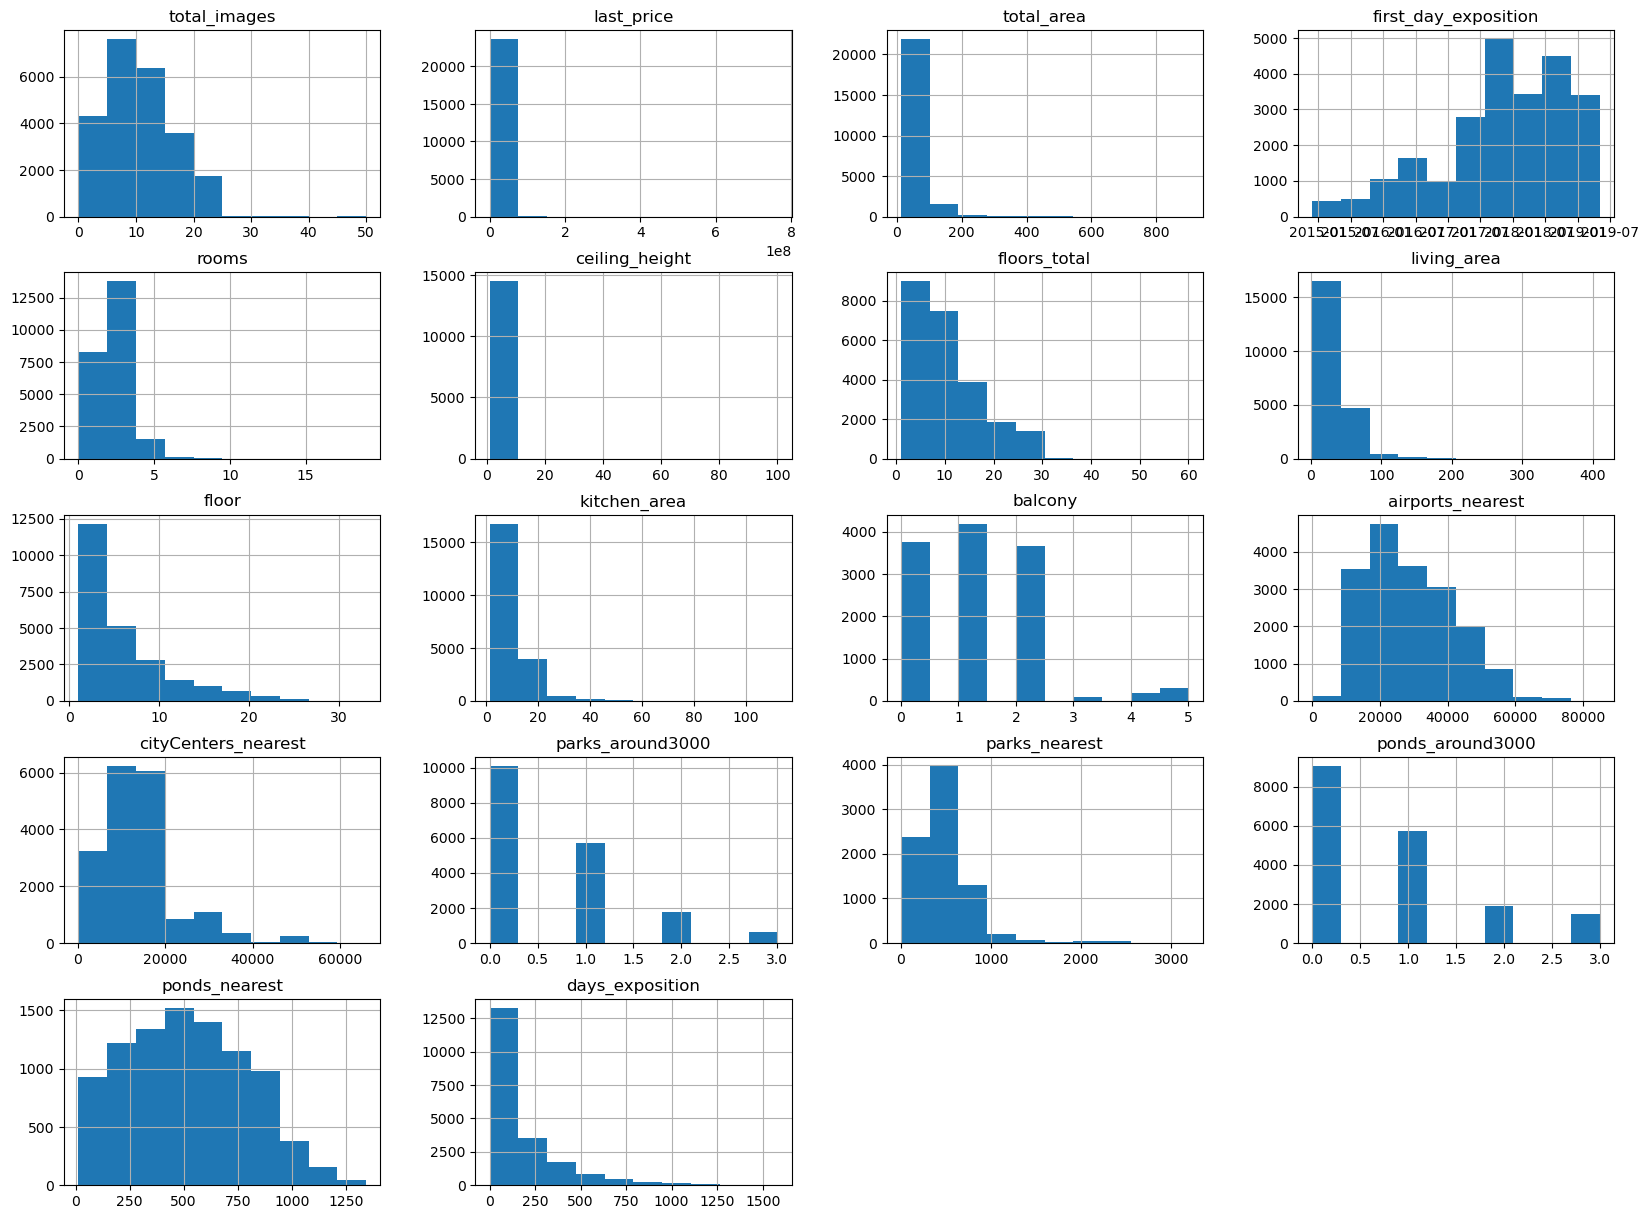

In [14]:
estate = main_info('real_estate_data.csv')

### Промежуточные выводы:

- В таблице 22 столбца и 23699 записей с информацией о продаже квартир.
- В таблице нет явных дубликатов, но зато есть пропуски значений в 14 столбцах.
- Доля пропусков в четырёх столбцах занимает более 40% от общего количества строк в датафрейме.
- Есть 0.2% пропусков в столбце с названием населённого пункта.
- В столбцах с высотой потолков и количеством этажей в здании тип данных вещественный вместо целочисленного.
- В некоторых столбцах присуствуют аномалии или выбросы:
    - слишком большое std и максимальное значение в столбце с ценой
    - максимальное значение количества комнат 19
    - максимальная высота потолков 100 м
    - максимальные значения для общей, жилой и площади кухни
- В основном, в объявлениях до 20 фотографий.
- Цена квартир, по большей части, сосредоточена до 100 млн рублей.
- В основном, общая площадь квартиры до 100 м²
- Количество комнат до 5, а количество балконов до двух в квартире.
- Высота потолков в объявлениях сосредоточена до 10 м, что явно сигнализирует об аномалиях в данном столбце (высота потолков выше 4 м в реальных квартирах не возможна).
- Этажность выставленных на продажу квартир сосредоточена до 20 этажа, а общая этажность здания до 30.

## Предобработка данных

### Обработка пропусков и аномалий

Посмотрим количество пропущенных значений для каждого столбца и долю пропущенных значний подробнее.

In [15]:
pd.DataFrame(round(estate.isna().mean().sort_values(ascending=False), 3))\
            .style.format('{:.1%}')\
            .background_gradient(cmap_table)

Из таблицы доли пропусков видно, что наибольшее количество пропусков имеет столбец булевого типа: является ли квартира апартаментами (88% пропусков). Пропусков в колонке количества этажей в здании и названии населённого пункта крайне мало: меньше 1%. Поэтому можно удалить эти значения из данных, так как их восстановить нельзя, а для дальнейшего анализа населённый пункт является важным параметром.

В столбцах с данными, которые брались автоматически с карты, наблюдается большой процент пропусков: больше 20% для каждого столбца, а для некоторых даже больше 60%. Но эти данные не особо важны для анализа влияния на стоимость квартиры и проверку объявлений, поэтому пропуски в таких столбцах можно оставить без изменений.

Удалим из данных пропуски в стобцах с названием населённого пункта и общим количеством этажей в здании. Количество удалённых данных составляет 0.6%.

In [16]:
# Переменная для контроля % удалённых значений
del_value = [0, estate.shape[0]]

In [17]:
estate = estate.dropna(subset=['locality_name', 'floors_total'])\
               .reset_index(drop=True)
del_value[0] = estate.shape[0]

In [18]:
print('Процент удалённых значений: ', 
      "{0:.1%}".format((del_value[1] - del_value[0]) / del_value[1]))

Процент удалённых значений:  0.6%


#### Балконы

Пропуски в столбце с количеством балконов, скорее всего, означают, что балконов в квартире нет. Такие пропуски можно заменить на 0. Также в столбце про апартаменты отсуствие информации означает, что квартира не является апартаментами, поэтому пропуски можно заполнить значением "False".

In [19]:
estate['balcony'] = estate['balcony'].fillna(0)
estate['is_apartment'] = estate['is_apartment'].fillna(False)

#### Количество комнат

В квартирах-студиях жилая площадь совмещена с площадью кухни, хотя по правилам они должны указываться отдельно друг от друга. Посмотрим, как обозначены квартиры с 0 комнатами в объявлении.

In [20]:
estate.groupby(['rooms'])['studio'].agg(['mean'])\
      .style.format('{:.1%}')\
      .background_gradient(cmap_table2)

Из таблицы видно, что большинство квартир, в которых 0 комнат, являются квартирой-студией (70% квартир). Для данных квартир площадь кухни может быть не указана, так как кухня совмещена с жилой площадью.

Также по таблице можно отметить, что существуют объявления с квартирами с 19 комнатами, что выглядит сомнительно. Максимальное количество комнат, которое может быть в квартире, соблюдающие все требования к жилому помещению, равняется 6 комнатам. Ещё одно возможное значение - 8 комнат могут получиться после объединения квартир на лестничной клетке и узаконенной перепланировки.

Посмотрим, какой процент объявлений по количеству комнат можно обозначить, как аномальный.

In [21]:
type_estate(data=estate, col_group='rooms', col_count='rooms')

In [22]:
print('95 и 99 перцентиль для количества комнат: ', 
      np.percentile(estate[~estate['rooms'].isna()]['rooms'], [95, 99]))
print('Процент квартир с комнатами больше 6: ', 
      "{0:.1%}".format(estate[estate['rooms'] > 6]['rooms'].count() / \
                       estate['rooms'].count()))

95 и 99 перцентиль для количества комнат:  [4. 5.]
Процент квартир с комнатами больше 6:  0.4%


Основная масса объявлений приходится на квартиры с количеством комнат от 1 до 3: больше 80%. Причём, по однокомнатным и двухкомнатным больший предложений. А на квартиры с количеством комнат от 6 суммарно приходится 0.4% (причём, 6 комнат это больше, чем 99 перцентиль, так что перепланировка с 8 комнатами является очень редким явлением). Удалим строчки с количеством комнат больше 6.

In [23]:
estate = estate.query('rooms <= 6').reset_index(drop=True)
del_value[0] = estate.shape[0]

#### Общая площадь квартиры

Посмотрим на гистограммы по общей площади квартиры.

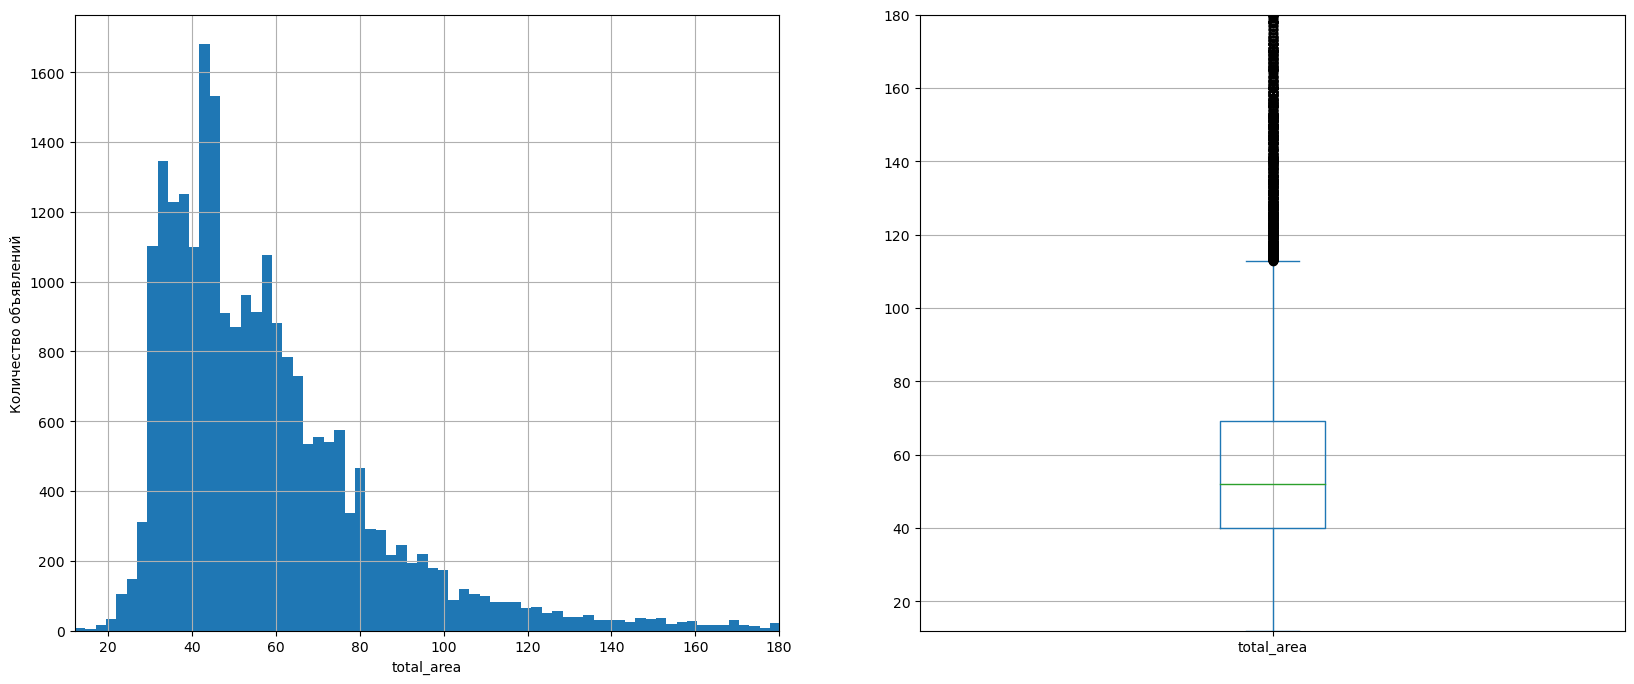

In [24]:
first_hist(data=estate, column='total_area', h_bins=200)

In [25]:
print('95 и 99 перцентиль для общей площади квартиры: ', 
      "{0:.1f}".format(np.percentile(estate['total_area'], 95)), ', '
      "{0:.1f}".format(np.percentile(estate['total_area'], 99)))

95 и 99 перцентиль для общей площади квартиры:  114.0 , 180.0


Медианное значение общей площади квартиры находится в области 50 м², а всё, что выше 115 м² считается выбросами. 99 перцентиль равняется 180 м², а 95 - 114 м². По гистограмме видно, что основное количество объявлений приходится на квартиры общей  площадью до 120 м². Причём, явно выражены четыре максимума: на квартиры 30 м², 45 м², 60 м² и 70 м² (примерные значения для однокомнатных, двухкомнатных и трёхкомнатных квартир).

*Есть требования по СП 54.13330.2016 «СНиП 31-01-2003 Здания жилые многоквартирные», чтобы общая площадь однокомнатной квартиры была 28-38 м², двухкомнатной - 44-53 м², трёхкомнатной - 56-65 м², четырёхкомнатной - 70-77 м², пятикомнатной - 84-96 м², а шестикомнатной - 103-109 м². Для жилой комнаты по площади нормы установлены на отметке не ниже 14 м², так что на квартиры-студии, когда комната совмещена с кухней, общая площадь должна быть не ниже 19 м². Конечно, эти нормы могут нарушаться, но это не является постоянными случаями, поэтому такие данные можно удалить из анализа.*

Предела по максимальному размеру квартир не существует, в России продаются квартиры и по 800 м², но это единичные случаи. Поэтому за отметку справа по общей площади квартиры можно принять значение равное 99 перцентилю в 180 м².

In [26]:
estate = estate.query('total_area >= 19 & total_area <= 180').reset_index(drop=True)
del_value[0] = estate.shape[0]

#### Жилая площадь квартиры

Посмотрим на гистограммы по жилой площади квартиры.

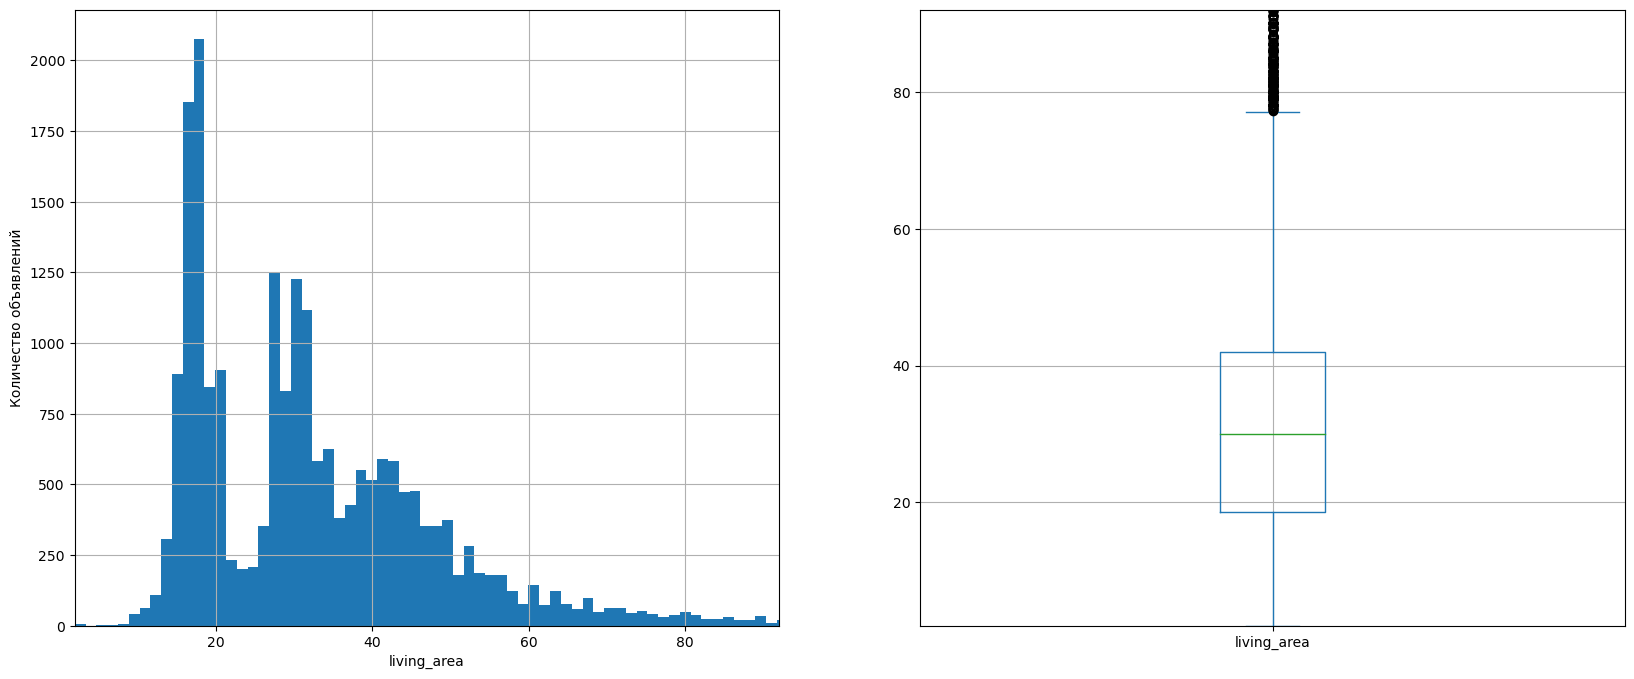

In [27]:
first_hist(data=estate, column='living_area', h_bins=100)

In [28]:
print('95 и 99 перцентиль для жилой площади квартиры: ', 
      "{0:.1f}".format(np.percentile(estate[~estate['living_area'].isna()]['living_area'], 95)), ', '
      "{0:.1f}".format(np.percentile(estate[~estate['living_area'].isna()]['living_area'], 99)))

95 и 99 перцентиль для жилой площади квартиры:  64.0 , 92.0


Медианное значение жилой площади квартиры равняется 30 м², а всё, что выше 80 м² считается выбросами. 99 перцентиль равняется 92 м², а 95 - 64 м². По гистограмме видно, что основное количество объявлений приходится на квартиры с жилой площадью до 60 м². Причём, явно выражены три максимума: на квартиры с жилой площадью 18 м², 30 м² и 45 м² (соотносится с значениями по количеству комнат).

*Есть требования по СП 54.13330.2016 «СНиП 31-01-2003 Здания жилые многоквартирные», чтобы жилая площадь одной комнаты была не ниже 14 м².*

По максимуму опять-таки ограничений нет, поэтому за ограничение справа можно принять значение, равное 99 перцентилю - 92 м².

In [29]:
estate = estate[((estate['living_area'] >= 14) & (estate['living_area'] <= 92))\
                | (estate['living_area'].isna())].reset_index(drop=True)
del_value[0] = estate.shape[0]

На площадь квартиры (общую, жилую, кухни) сильное влияние оказывает количество комнат. После удаления аномальных значений по жилой площади квартиры, можно избавиться от пропусков, заменив пропущенные значения на медианные в зависимости от количества комнат.

In [30]:
for t in estate['rooms'].unique():
    estate.loc[(estate['rooms'] == t) & (estate['living_area'].isna()), 'living_area'] = \
    estate.loc[(estate['rooms'] == t), 'living_area'].median()

#### Площадь кухни

Посмотрим на гистограммы по площади кухни в квартире.

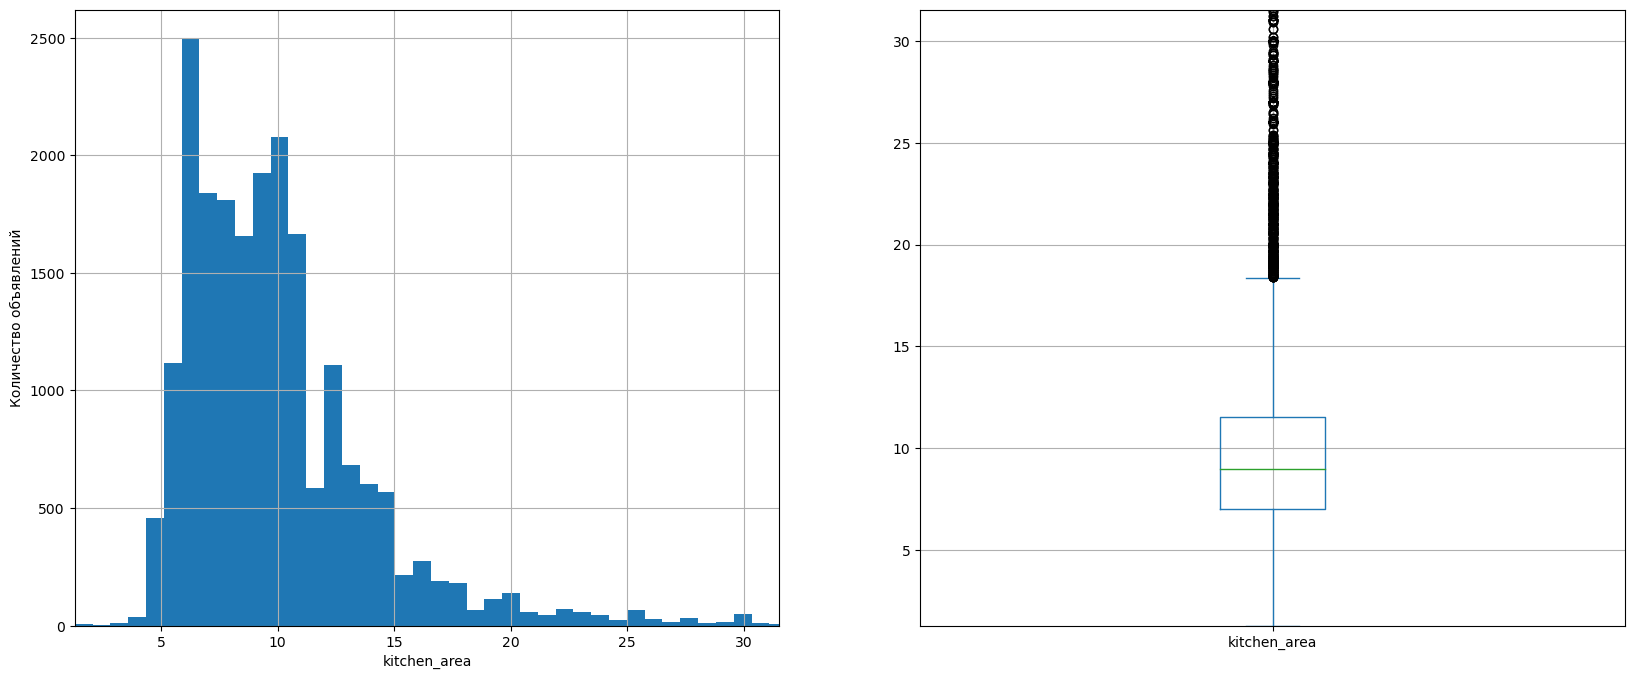

In [31]:
first_hist(data=estate, column='kitchen_area', h_bins=120)

In [32]:
print('95 и 99 перцентиль для площади кухни: ', 
      "{0:.1f}".format(np.percentile(estate[~estate['kitchen_area'].isna()]['kitchen_area'], 95)), ', '
      "{0:.1f}".format(np.percentile(estate[~estate['kitchen_area'].isna()]['kitchen_area'], 99)))

95 и 99 перцентиль для площади кухни:  18.5 , 31.5


Медианное значение площади кухни равняется 8 м², а всё что выше 17 м², считается выбросами. 99 перцентиль равняется 31 м², а 95 - 18 м². По гистограмме видно, что основное количество объявлений приходится на квартиры с площадью кухни до 20 м². В этот раз явно выражены три максимума: на квартиры с площадью кухни 6 м², 9 м² и 12 м².

*Есть требования по СП 54.13330.2016 «СНиП 31-01-2003 Здания жилые многоквартирные», чтобы площадь кухни для однокомнатной квартиры была не ниже 5 м². Для квартир-студий это значение может не указываться.*

По максимуму ограничений нет, поэтому за ограничение справа можно принять значение, равное 99 перцентилю - 32 м².

In [33]:
estate = estate[((estate['kitchen_area'] >= 5) & (estate['kitchen_area'] <= 32))\
                | (estate['kitchen_area'].isna())].reset_index(drop=True)
del_value[0] = estate.shape[0]

Для квартир-студий возможно совмещение кухни с комнатой, посмотрим на квартиры с 0 комнат.

In [34]:
estate.query('rooms == 0').groupby(by=['rooms'])\
                          .agg(total_area = ('total_area', 'mean'),
                               living_area = ('living_area', 'mean'),
                               kitchen_area = ('kitchen_area', 'mean'))

total_area  living_area  kitchen_area
rooms                                       
0       28.049111    19.351333           NaN

Для квартир с 0 комнат (большая часть из них в объявлениях отмечена как "квартира-студия") не указана площадь кухни, но при этом указаны общая площадь квартиры и жилая площадь. Таким образом, можно заполнить пропуски в площади кухни для объявлений с 0 комнат значением "0", а пропуски для остального количества комнат заполнить медианным значением.

In [35]:
for t in estate['rooms'].unique():
    if t != 0:
        estate.loc[(estate['rooms'] == t) \
                   & (estate['kitchen_area'].isna()), 'kitchen_area'] = \
        estate.loc[(estate['rooms'] == t), 'kitchen_area'].median()
    else:
        estate.loc[(estate['rooms'] == t) \
                   & (estate['kitchen_area'].isna()), 'kitchen_area'] = 0

#### Высота потолков

Посмотрим на значения высоты потолков.

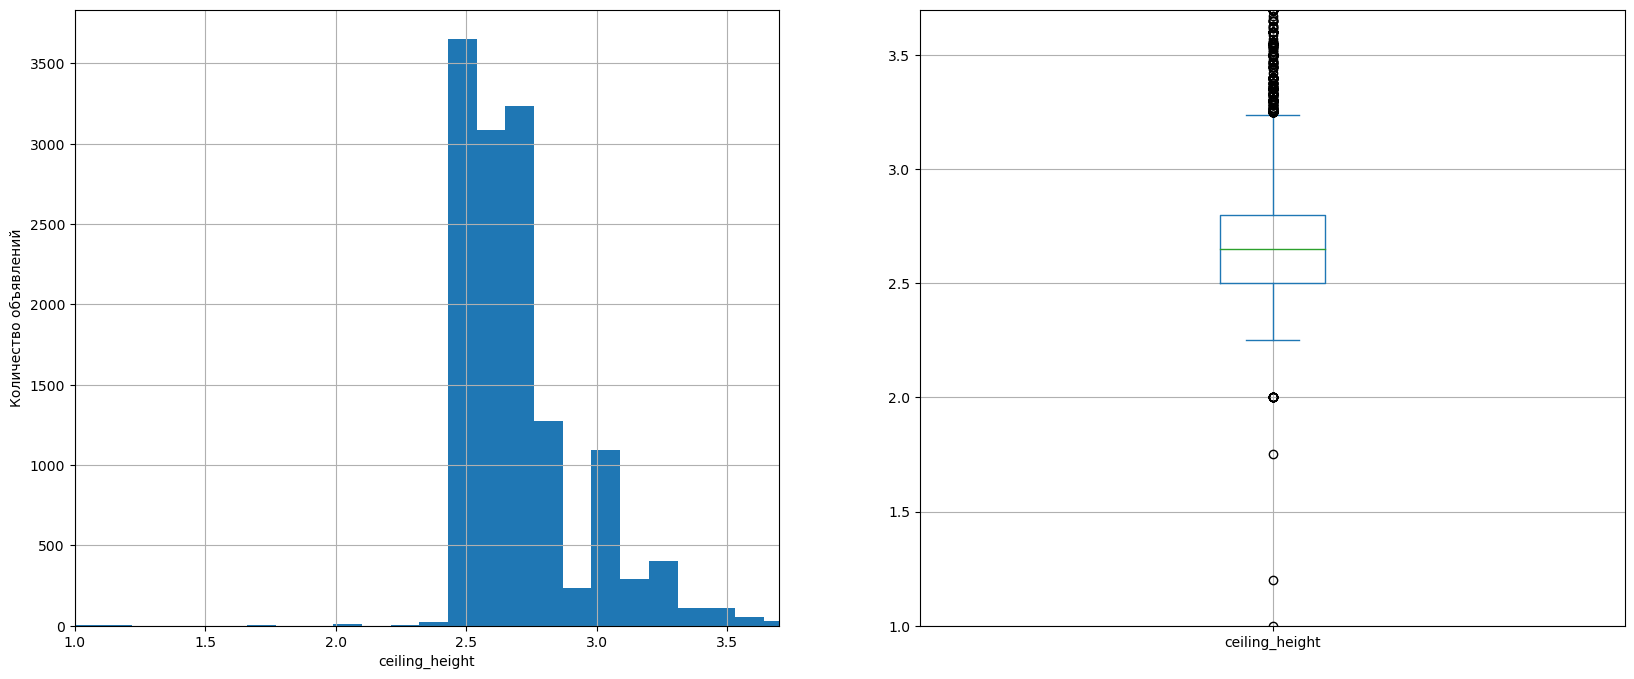

In [36]:
first_hist(data=estate, column='ceiling_height', h_bins=900)

In [37]:
print('95 и 99 перцентиль для высоты потолков: ', 
      "{0:.1f}".format(np.percentile(estate[~estate['ceiling_height'].isna()]['ceiling_height'], 95)), ', '
      "{0:.1f}".format(np.percentile(estate[~estate['ceiling_height'].isna()]['ceiling_height'], 99)))

95 и 99 перцентиль для высоты потолков:  3.2 , 3.7


Медианное значение высоты потолков находится в области 2.6 м, а всё, что выше 3.25 м считается выбросами. 99 перцентиль равняется 3.8 м, а 95 - 3.3 м. По гистограмме видно, что основное количество объявлений приходится на 2.5 м, при этом есть часть объявлений приходится на 3 м по высоте потолков. И потолки ниже 2.25 м считаются выбросами и единичными случаями.

*Есть требования по СП 54.13330.2016 «СНиП 31-01-2003 Здания жилые многоквартирные», чтобы высота потолков в многоквартирном доме была не ниже 2.5-2.7 м. В дореволюционных домах высота потолков колебалась от 2 до 4,5 м. Все потолки, которые выше данных значений, считаются высокими. Ограничения по высоте в России нет, но все высокие потолки, которые выше 4 м считаются нетипичными и являются единичными случаями.*

Посмотрим на уникальные значение в колонке с высотой потолков.

In [38]:
estate['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.25,   2.3 ,   2.34,   2.4 ,
         2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,   2.52,
         2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,   2.6 ,
         2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,   2.68,
         2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,   2.76,
         2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,   2.84,
         2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,   2.92,
         2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,   3.  ,
         3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,   3.08,
         3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,   3.16,
         3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,   3.25,
         3.26,   3.27,   3.28,   3.3 ,   3.31,   3.32,   3.33,   3.34,
         3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,   3.42,   3.44,
         3.45,   3.46,   3.47,   3.48,   3.49,   3.5 ,   3.52,   3.53,
      

Как можно видеть, некоторые значения выглядят аномально. Например 32 м и 27 м. Скорее всего, при вводе данных ошиблись с проставлением плавающей запятой, и такие значения можно подкорректировать.

In [39]:
estate.loc[estate['ceiling_height'] > 9, 'ceiling_height'] = estate['ceiling_height'] / 10

Посчитаем количество аномальных выбросов после исправления части значений за счёт сдвига плавающей запятой. За границы допустимых значений возьмём высоту потолков между 2 и 4 м (2 - минимальная высота, допустимая в дореволюционных квартирах, 4 - максимальная высота, возможная в двухэтажных квартирах).

In [40]:
print('Процент объявлений для квартир с высотой потолков ниже 2 м и выше 4 м: ', 
      "{0:.1%}".format(estate.query('ceiling_height <= 2 | ceiling_height >= 4')\
                        ['ceiling_height'].count() / estate['ceiling_height'].count()))

Процент объявлений для квартир с высотой потолков ниже 2 м и выше 4 м:  0.6%


Таких значений всего лишь 0.6% от значений всего датафрейма. Удалим их.

In [41]:
estate = estate[~((2 >= estate['ceiling_height']) | (4 <= estate['ceiling_height']))]\
               .reset_index(drop=True)
del_value[0] = estate.shape[0]

Есть предположение, что на высоту потолка будет влиять тип здания, в котором квартира находится и, возможно, этажность здания. После удаления аномальных значений, можно заполнить пропуски в столбце с высотой потолков медианным значением в зависимости от этажа квартиры.

Проверим, сколько значений по высоте потолков есть для каждого этажа, а сколько из них пропущено.

In [42]:
type_estate(data=estate, col_group='floor', col_count='ceiling_height')

С 26 по 30 этаж крайне мало значений по высоте потолков. Посчитаем количество объявлений с 26 по 30 этаж.

In [43]:
print('Процент объявлений для квартир с этажностью здания выше 26: ', 
      "{0:.1%}".format(estate[estate['floor'] >= 26]['floor'].count()\
                 / estate['floor'].count()))

Процент объявлений для квартир с этажностью здания выше 26:  0.2%


Таких объявлений всего 0.2% от значений в датафрейме. Их можно удалить из данных, так как данных по ним будет недостаточно для анализа, а остальные пропуски можно заполнить медианой.

In [44]:
estate = estate[estate['floor'] < 26].reset_index(drop=True)
del_value[0] = estate.shape[0]
for t in estate['floor'].unique():
    estate.loc[(estate['floor'] == t) & (estate['ceiling_height'].isna()), 'ceiling_height'] = \
    estate.loc[(estate['floor'] == t), 'ceiling_height'].median()

#### Водоёмы и парки

В датафрейме есть данные, которые не были вписаны пользователем, а были получены автоматически на основе картографических данных. Пропуски в таких столбцах могут означать, что в ближайшей доступности от квартиры нет водоёмов, парков и аэропортов. Иначе, по указанному пользователем месту расположения квартиры данные были бы автоматически отмечены. Заполним пропуски в таких столбцах 0.

In [45]:
estate['parks_around3000'] = estate['parks_around3000'].fillna(0)
estate['ponds_around3000'] = estate['ponds_around3000'].fillna(0)

Остальные пропуски оставим без изменения, так как параметры в данных столбцах не являются обязательными в исследовании, а заполнить такие пропуски значениями не представляется возможным.

#### Цена квартиры

В столбце с ценой для более наглядных значений цену перепишем в млн рублей вместо просто рублей.

In [46]:
estate['last_price'] = estate['last_price'] / 1e6

Посмотрим на гистограммы по цене квартиры.

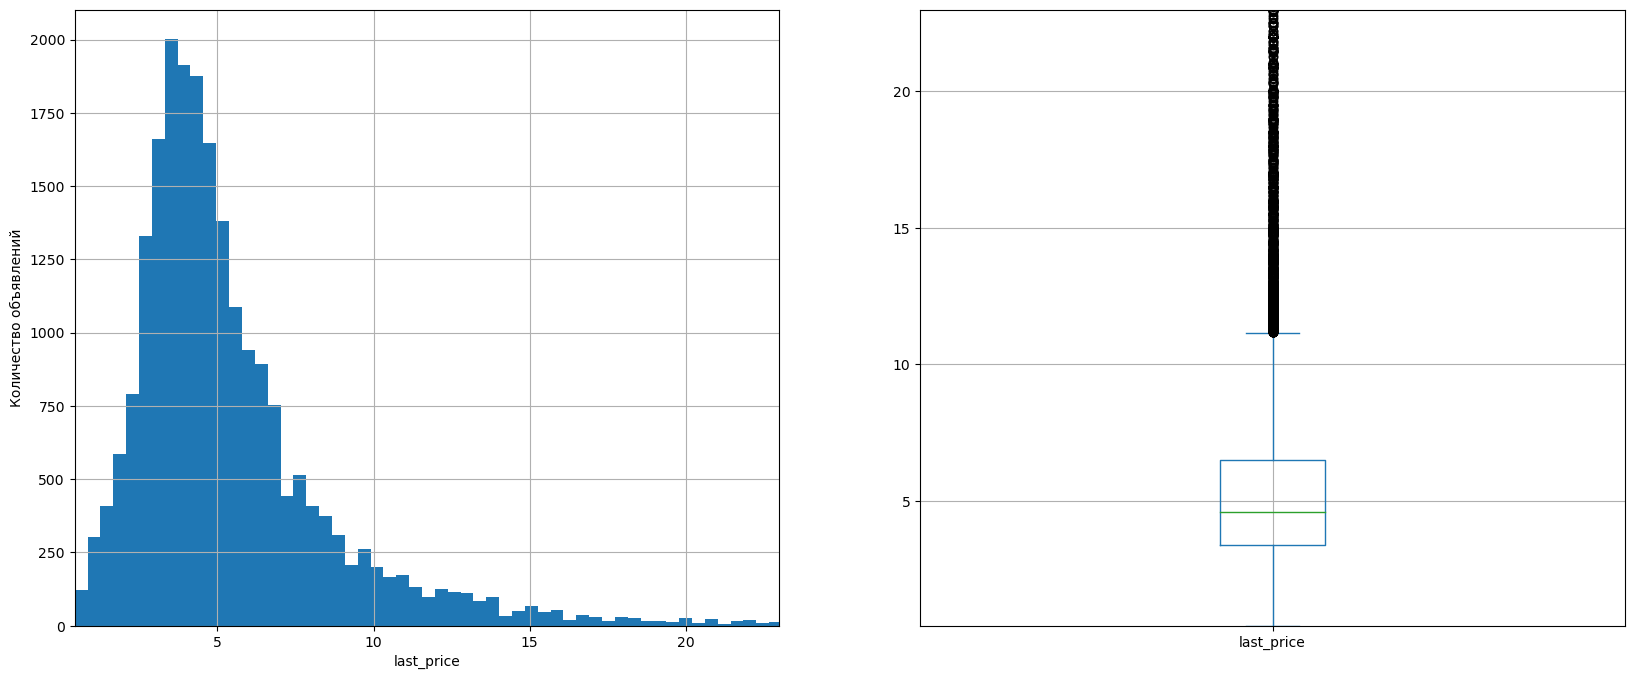

In [47]:
first_hist(data=estate, column='last_price', h_bins=300)

In [48]:
print('95 и 99 перцентиль для цены квартиры: ', 
      "{0:.1f}".format(np.percentile(estate['last_price'], 95)), ', '
      "{0:.1f}".format(np.percentile(estate['last_price'], 99)))

95 и 99 перцентиль для цены квартиры:  12.6 , 23.0


Медианное значение цены квартиры находится в области 5 млн рублей, а всё, что выше 11 млн считается выбросами. 99 перцентиль равняется 23 млн, а 95 - 13 млн. По гистограмме видно, что основное количество объявлений приходится на квартиры ценой до 15 млн. Причём, максимум приходится на 4 млн рублей.

Предела по минимуму или максимуму цены не существует. Она зависит от многих факторов: расположения, площади квартиры, удобств и инфраструктуры рядом. Поэтому можно удалить из датафрейма квартиры, стоящие больше, чем 99 перцентиль - 23 млн.

In [49]:
estate = estate.query('last_price <= 23').reset_index(drop=True)
del_value[0] = estate.shape[0]

In [50]:
print('Процент удалённых значений: ', 
      "{0:.1%}".format((del_value[1] - del_value[0]) / del_value[1]))

Процент удалённых значений:  6.9%


Проверим, что все возможные пропуски были обработаны:

In [51]:
pd.DataFrame(round(estate.isna().mean().sort_values(ascending=False), 3))\
            .style.format('{:.1%}')\
            .background_gradient(cmap_table)

Пропуски были оставлены только в 5 столбцах: в тех, для которых данные брались автоматически с карты по адресу объявления квартиры (ближайшие парки и водоёмы рядом, расстояние до аэропорта и центра) и количество дней размещения объявления. Пропуски в последнем столбце могут означать, что объявление до момента выгрузки данных находилось в активных объявлениях, а не завершённых. Но, так как дата выгрузки данных не известна, заполнить пропуски в этом столбце не предоставляется возможным.

#### Промежуточные выводы:

- В столбце с количеством балконов было 48% пропусков. Они были заполнены значением "0".
- В столбце с апартаментами было 88% пропусков. Они были заполнены значением "False".
- Были удалены аномальные значения в столбце с количеством комнат. Всё, что больше 6 комнат считалось аномальным.
- Ограничение сверху было по 99 перцентилю.
- Аномальными считались значения снизу, которые не согласовались с требованиями в России к площади квартир:
    - По общей площади аномальными считались квартиры: меньше 19 м² и больше 160 м².
    - По жилой площади аномальными считались квартиры: меньше 14 м² и больше 85 м².
    - По площади кухни аномальными считались квартиры: меньше 5 м² и больше 30 м².
    - Были оставлены значения по площади кухни, равные 0 м², так как они соответствовали квартирам-студиям, в которых площадь кухни совмещена с жилым помещением.
- По цене аномальным считалось значение выше 33 млн.
- Пропуски в столбце с жилой площадью квартиры и площадью кухни были заменены на медианные в зависимости от количества комнат.
- Для квартир с 0 комнат пропуски в площади кухни были заполнены значением "0", так как это квартиры-студии.
- Были исправлены значения в столбце с высотой потолков, когда пользователь мог ошибиться с проставлением плавающей запятой.
- Все остальные аномальные значения в столбце с высотой потолков были удалены. Всё, что меньше 2 м и выше 4 м считалось аномальным.
- В столбце в высотой потолков пропуски были заполнены медианным значением в зависимости от этажа квартиры.
- В остальных столбцах (5 штук) пропуски были оставлены, так как восстановить в них значения не предоставляется возможным, а данные в этих столбцах проставлялись не пользователем, а автоматически.
- Удалённые данные составили 6.9% от всех данных в датафрейме.

### Изменение типов данных

Приведём типы данных в стобцах к правильным значениям.

In [52]:
estate.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                        float64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

В столбцах с количеством этажей, количеством балконов, количеством парков и водоёмов можно изменить тип данных на целочисленный, так как дробного числа для данных категорий не бывает. Обработка пропусков в этих столбцах была проведена, так что можно заменить тип данных на правильный.

Так как в столбце с количеством дней публикации всё ещё есть пропущенные значения, заполнить пропуски нечем, а NaN считается типом данных float64, то изменить тип данных в данном столбце не получится.

In [53]:
columns_type_to_replace =['floors_total', 'balcony',
                          'ponds_around3000', 'parks_around3000']
for column_type in columns_type_to_replace:
    estate[column_type] = columns_type_replace(column_type)
estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22067 entries, 0 to 22066
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22067 non-null  int64         
 1   last_price            22067 non-null  float64       
 2   total_area            22067 non-null  float64       
 3   first_day_exposition  22067 non-null  datetime64[ns]
 4   rooms                 22067 non-null  int64         
 5   ceiling_height        22067 non-null  float64       
 6   floors_total          22067 non-null  int64         
 7   living_area           22067 non-null  float64       
 8   floor                 22067 non-null  int64         
 9   is_apartment          22067 non-null  bool          
 10  studio                22067 non-null  bool          
 11  open_plan             22067 non-null  bool          
 12  kitchen_area          22067 non-null  float64       
 13  balcony         

### Обработка дубликатов

Посмотрим на уникальные значения в столбце с населённым пунктом.

In [54]:
print('Количество уникальных значений населённых пунктов: ', 
      estate['locality_name'].nunique())

Количество уникальных значений населённых пунктов:  360


In [55]:
estate['locality_name'].unique()[0:50]

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин',
       'посёлок Парголово', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'посёлок Мурино', 'Гатчина',
       'поселок Мурино', 'деревня Фёдоровское', 'Выборг', 'Кронштадт',
       'Кировск', 'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет', 'Сланцы',
       'село

В названиях населённых пунктов встречаются дубликаты: посёлок, поселок, поселок городского типа и тд. Во избежание повторов приведём приставки в названии населённого пункта к типичным значениям: посёлок, посёлок станции, садовое товарищество.

In [56]:
estate = estate.apply(lambda x: x.replace({'посёлок городского типа': 'посёлок',
                                           'поселок городского типа': 'посёлок',
                                           'городской посёлок': 'посёлок', 
                                           'городской поселок': 'посёлок',
                                           'коттеджный посёлок': 'посёлок', 
                                           'коттеджный поселок': 'посёлок', 
                                           'поселок станции': 'посёлок станции',
                                           'посёлок при железнодорожной станции': 'посёлок станции',
                                           'поселок при железнодорожной станции': 'посёлок станции',
                                           'садоводческое некоммерческое товарищество': 'садовое товарищество',
                                           'поселок':'посёлок'
                                          }, regex=True))

In [57]:
print('Количество уникальных значений населённых пунктов: ', 
      estate['locality_name'].nunique())

Количество уникальных значений населённых пунктов:  315


После замены осталось 315 уникальных названий населённых пунктов вместо 360.

### Добавление в таблицу новых столбцов

Добавим в датафрейм новые столбцы для дальнейшего детального изучения данных.

Выделим отдельно первый и последний этаж квартиры. Выделим столбцы с ценой (тыс рублей) за 1 м², годом, месяцем и неделей размещения объявления, типом этажа квартиры и расстояние до центра в км.

In [58]:
estate['price_meter'] = (estate['last_price'] / estate['total_area']) * 1e3
estate['week_exposition'] = estate['first_day_exposition'].dt.weekday
estate['month_exposition'] = estate['first_day_exposition'].dt.month
estate['year_exposition'] = estate['first_day_exposition'].dt.year
estate['type_floor'] = estate.apply(type_of_floor, axis=1)
estate['cityCenters_nearest_km'] = round(estate['cityCenters_nearest'] / 1e3)

Получим общую информацию о данных. Убедимся, что предобработка выполнена успешно.

In [59]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22067 entries, 0 to 22066
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            22067 non-null  int64         
 1   last_price              22067 non-null  float64       
 2   total_area              22067 non-null  float64       
 3   first_day_exposition    22067 non-null  datetime64[ns]
 4   rooms                   22067 non-null  int64         
 5   ceiling_height          22067 non-null  float64       
 6   floors_total            22067 non-null  int64         
 7   living_area             22067 non-null  float64       
 8   floor                   22067 non-null  int64         
 9   is_apartment            22067 non-null  bool          
 10  studio                  22067 non-null  bool          
 11  open_plan               22067 non-null  bool          
 12  kitchen_area            22067 non-null  float6

### Промежуточные выводы:

Была проведена предобработка данных для таблицы с объявлениями о продаже недвижимости:
- В таблице не было явных дубликатов, но зато были пропуски значений в 14 столбцах.
- Доля пропусков в четырёх столбцах занимала более 40% от общего количества строк в датафрейме.
- Были удалены аномальные значения из пяти столбцов.
- Аномальными считались значения снизу, которые не согласовались с требованиями в России к квартирам.
- Ограничение сверху было по 99 перцентилю.
- После удаления аномалий, в тех столбцах, где это было возможным, пропуски были заполнены медианными значениями в зависимости от типа квартиры.
- В пяти столбцах пропуски были оставлены, так как восстановить в них значения не предоставляется возможным.
- Удалённые данные составили 6.9% от всех данных в датафрейме.
- Типы данных в с толбцах были приведены к правильным.
- Были заменены неявные дубликаты из столбца с названием населённого пункта. После замены осталось 315 уникальных названий населённых пунктов вместо 360.
- В таблицу были добавлены новые столбцы: с годом, месяцем и неделей размещения объявления, с ценой (тыс рублей) за 1 м², типом этажа квартиры и расстояние до центра в км.
- Данные подготовлены для дальнейшего анализа.

## Исследовательский анализ данных

### Зависимость объявлений от даты размещения

#### Год

Посмотрим подробнее на зависимость количества объявлений от года размещения:

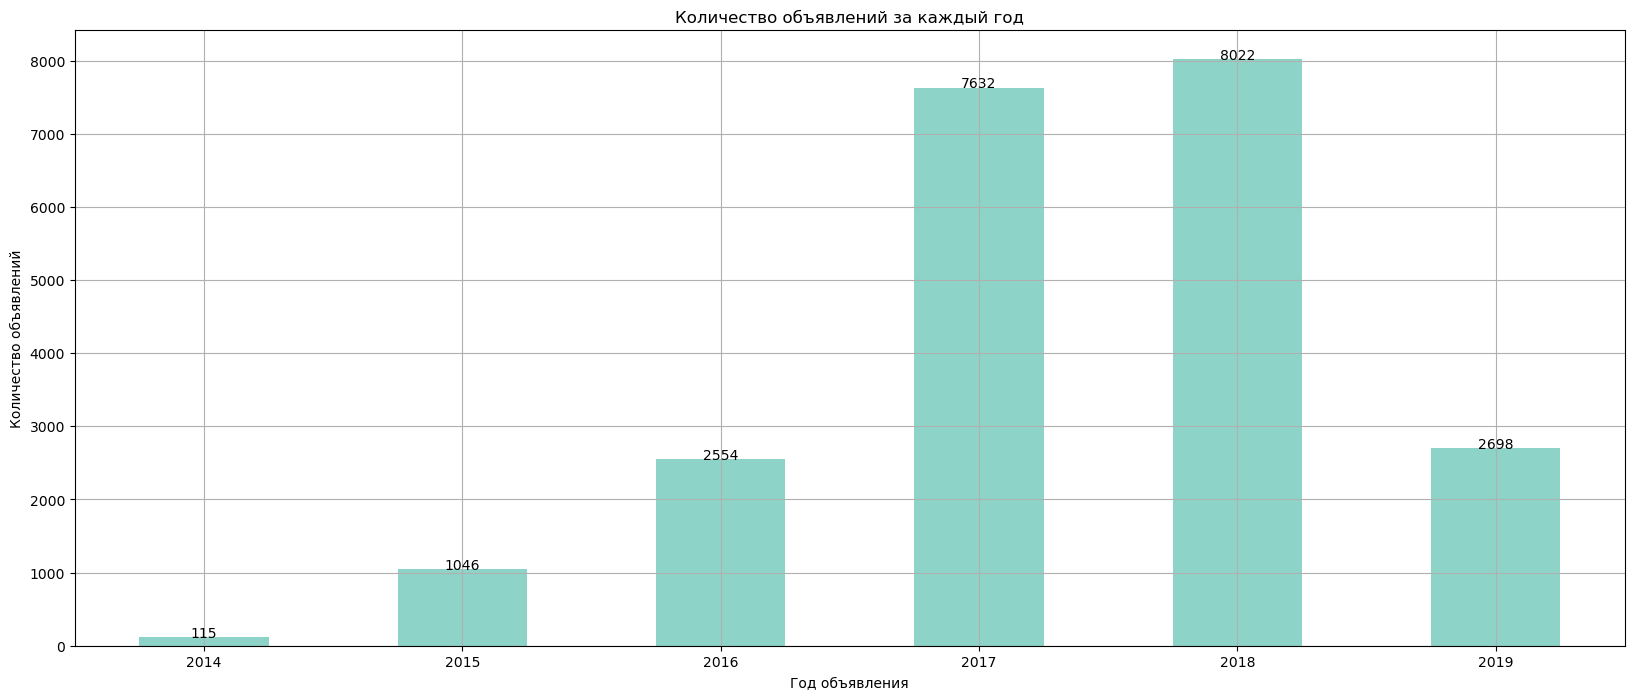

In [60]:
df = table_pivot(data=estate, col_group=['year_exposition'], values='rooms', func='count')
fig = bar_plot(data=df, col_group='year_exposition')
plt.xticks(rotation=0)
addlabels(x=df['year_exposition'], y=df['total'])
plt.xlabel('Год объявления')
plt.ylabel('Количество объявлений')
plt.title('Количество объявлений за каждый год')
plt.show();

Объявления представлены за 6 лет: с 2014 по 2019 год включительно. При этом максимальное количество объявлений пришлось на 2017 и 2018 года. В остальные года объявлений было в разы меньше. С 2015 по 2018 наступил рост числа объявлений (в 2017 году был резкий скачок).

Проверим крайние года, за сколько месяцев был сбор данных, так как спад количества объявлений в 2019 году выглядит странно (резкое удорожание квартир случилось только в 2020 году, следовательно, в 2019 году должно было подаваться достаточное количество объявлений о продаже).

In [61]:
print('Месяца в 2014 году, взятые в расчёт: ', 
      estate.query('year_exposition == 2014')['month_exposition'].sort_values().unique())
print('Месяца в 2019 году, взятые в расчёт: ', 
      estate.query('year_exposition == 2019')['month_exposition'].sort_values().unique())

Месяца в 2014 году, взятые в расчёт:  [11 12]
Месяца в 2019 году, взятые в расчёт:  [1 2 3 4 5]


Данные за 2019 год представлены не за полный год, а только за 5 месяцев. Это объясняет то, что на гистограмме объявлений в 2019 году в 2.5 раза меньше, чем за 2017 и 2018 года. А в 2014 году в расчёт были взяты только 2 месяца: ноябрь и декабрь. Следовательно, нельзя однозначно говорить, что в 2014 или 2019 года было меньше объявлений по сравнению с соседними.

#### Месяц

Посмотрим, имел ли влияние месяц размещения объявления.

In [62]:
df = estate.query('year_exposition != 2014').groupby(['month_exposition','year_exposition'], as_index=False)\
                    [['last_price']].count()
fig = px_plot(data=df, col_group='month_exposition', col_value='last_price', col_color='year_exposition')
fig.update_layout(title='Количество объявлений в зависимости от месяца публикации',
                  xaxis_title='Месяц объявления',
                  yaxis_title='Количество объявлений',
                  legend_title='Год')
fig.show()

Если посмотреть на разбивку по годам, то можно отметить, что в разные года зависимость от месяца объявления была несколько разной. 
- Так, в 2015 с февраля по март было увеличение объявлений, в апреле наблюдается просадка, но затем было плавное увеличение до скачка с увеличением количества в октябре и отсутствием спадов до конца года. 
- В 2016 году до июня было только учеличение количества объявлений, а в июле произошёл спад, и до конца года количество объявлений осталось примерно одинаковым. 
- Для 2017 года было скачкообразное повышение до конца года, а сильная просадка только в декабре и марте. 
- Для 2018 года (видимо, он на общую картину по месяцам повлиял сильнее всего) был резкий скачок в феврале, далее резкий спад до мая (в мае был минимум объявлений за весь год), повышение до июня, и резкий спад в декабре. 
- В 2019 году же наблюдается увеличение количества объявлений до апреля. За май данные представлены не полностью, поэтому визуально кажется, что большая просадка.

Посмотрим на все года совместно.

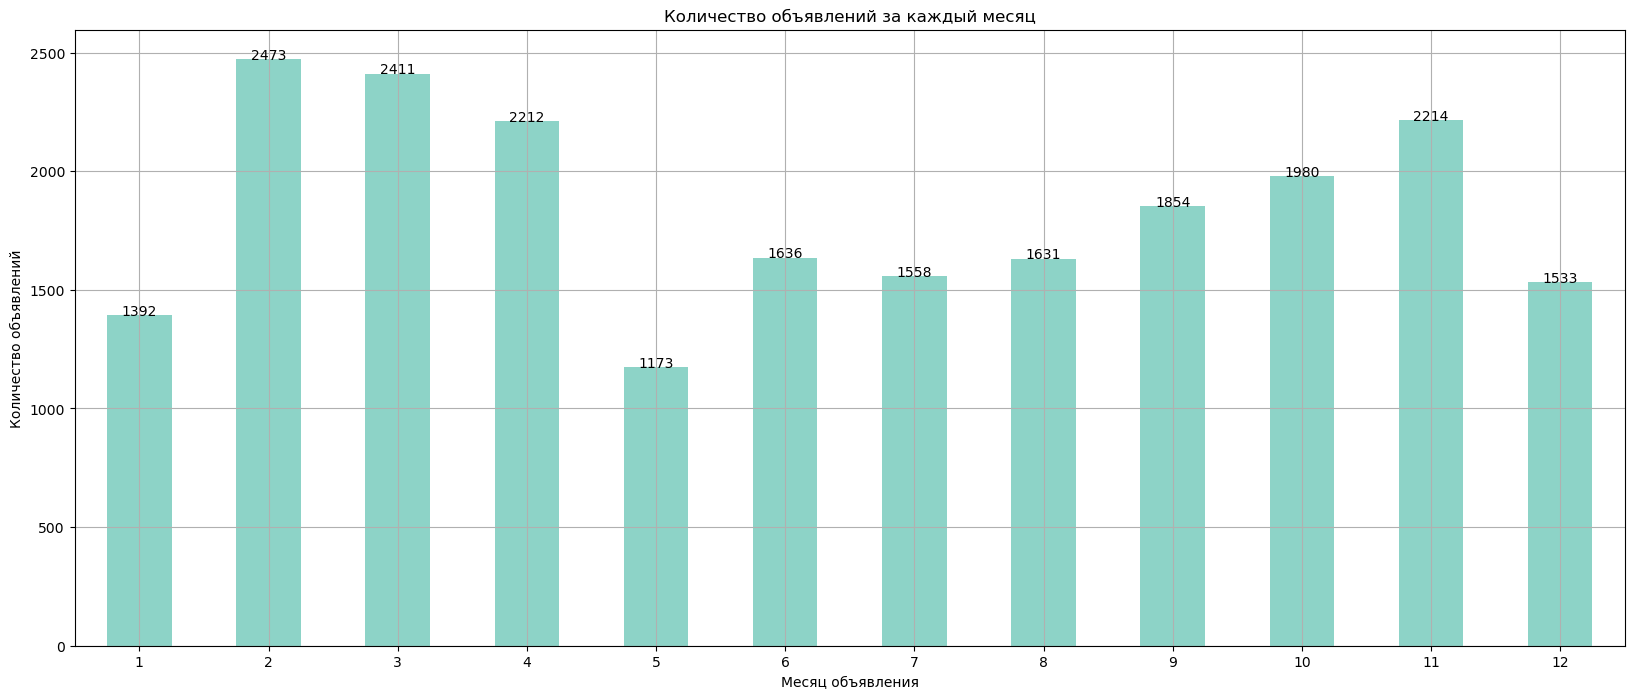

In [63]:
df = table_pivot(data=estate, col_group='month_exposition', values='rooms', func='count')
fig = bar_plot(data=df, col_group='month_exposition')
plt.xticks(rotation=0)
addlabels(x=df['month_exposition'], y=df['total'])
plt.xlabel('Месяц объявления')
plt.ylabel('Количество объявлений')
plt.title('Количество объявлений за каждый месяц')
plt.show();

В феврале происходит резкое увеличение количества объявлений по отношению к январю, и начинает плавно снижаться до мая (в мае объявлений даже меньше, чем в январе). С июня по ноябрь идёт повышение, в ноябре достигает пиковых значений, а в декабре снова наблюдается просадка, но всё равно объявлений больше, чем для января и мая. Провалы в графике согласуются с большим количеством праздничных дней в январе и мае и приближению Нового Года в декабре. Видимо, на общее распределение количества объявлений от месяца размещения, имеет сильное влияние 2018 год, так как наблюдается общая картина, как для этого года.

#### День недели

Посмотрим, как на размещение объявления влияет день недели.

In [64]:
df = estate.query('year_exposition != 2014').groupby(['week_exposition','year_exposition'], as_index=False)\
                    [['last_price']].count()
fig = px_plot(data=df, col_group='week_exposition', col_value='last_price', col_color='year_exposition')
fig.update_layout(title='Количество объявлений в зависимости от дня недели публикации',
                  xaxis_title='День недели объявления',
                  yaxis_title='Количество объявлений',
                  legend_title='Год')
fig.show()

Для каждого из годов размещения наблюдается общая тенденция: уменьшение количества объявлений в выходные дни.

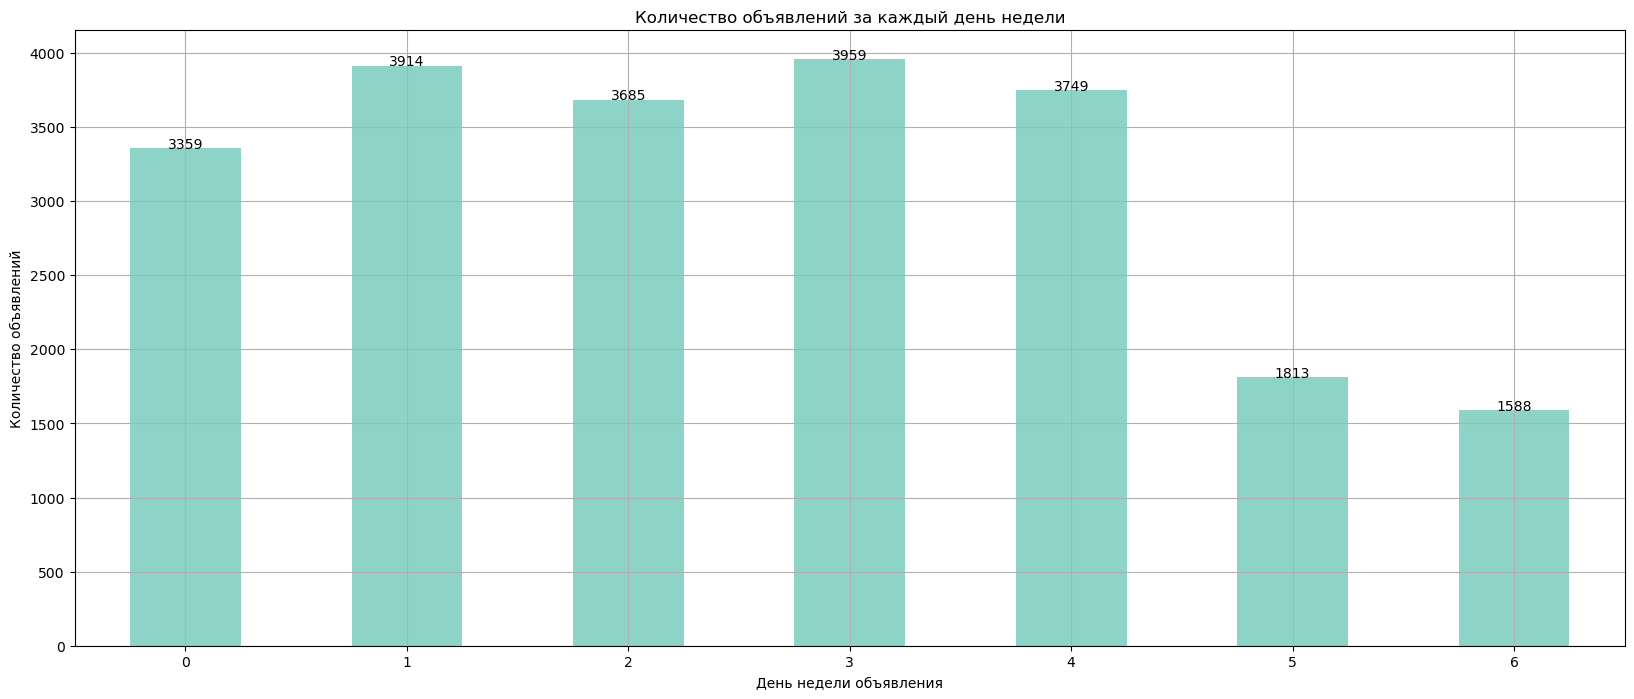

In [65]:
df = table_pivot(data=estate, col_group='week_exposition', values='rooms', func='count')
fig = bar_plot(data=df, col_group='week_exposition')
plt.xticks(rotation=0)
addlabels(x=df['week_exposition'], y=df['total'])
plt.xlabel('День недели объявления')
plt.ylabel('Количество объявлений')
plt.title('Количество объявлений за каждый день недели')
plt.show();

В будние дни количество объявлений примерно одинаково, а в выходные дни наступает резкий спад (почти в 2 раза меньше, чем в будние). Это можно объяснить тем, что в будние дни люди чаще занимаются размещением объявлений (скорее, обращаются в риелторские агенства, которые работают как раз по будним дням).

### Популярные объявления

Посмотрим на то, какие чаще всего выкладывают объявления о продаже квартир (после удаления аномалий из данных).

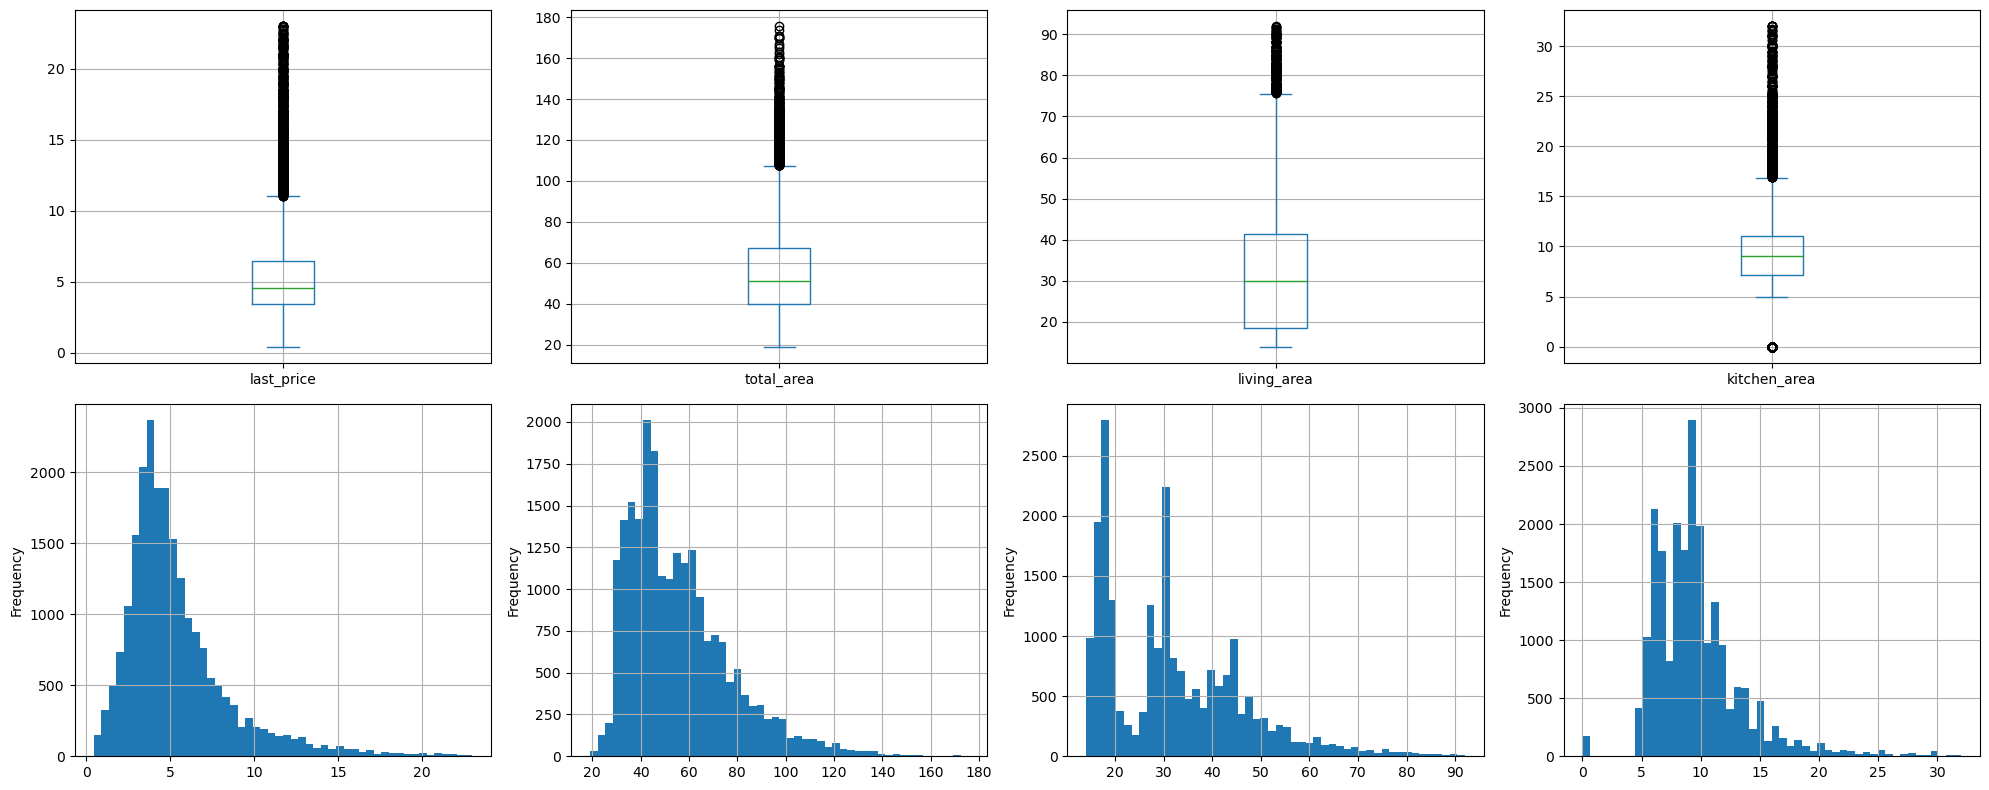

In [66]:
typical_hist(estate, ['last_price', 'total_area', 'living_area', 'kitchen_area'])

Чаще всего за 6 лет на сайт выставляли квартиры ценой в 4 млн, с общей площадью 50 м², жилой площадью 30 м² и площадью кухни 8 м². При этом можно отметить, что по общей площади квартиры видны два максимума: для однокомнатных и для двухкомнатных квартир, третий максимум для трёхкомнатных квартир слабо выражен. Зато он более явно выражен на распределении для жилой площади квартиры.

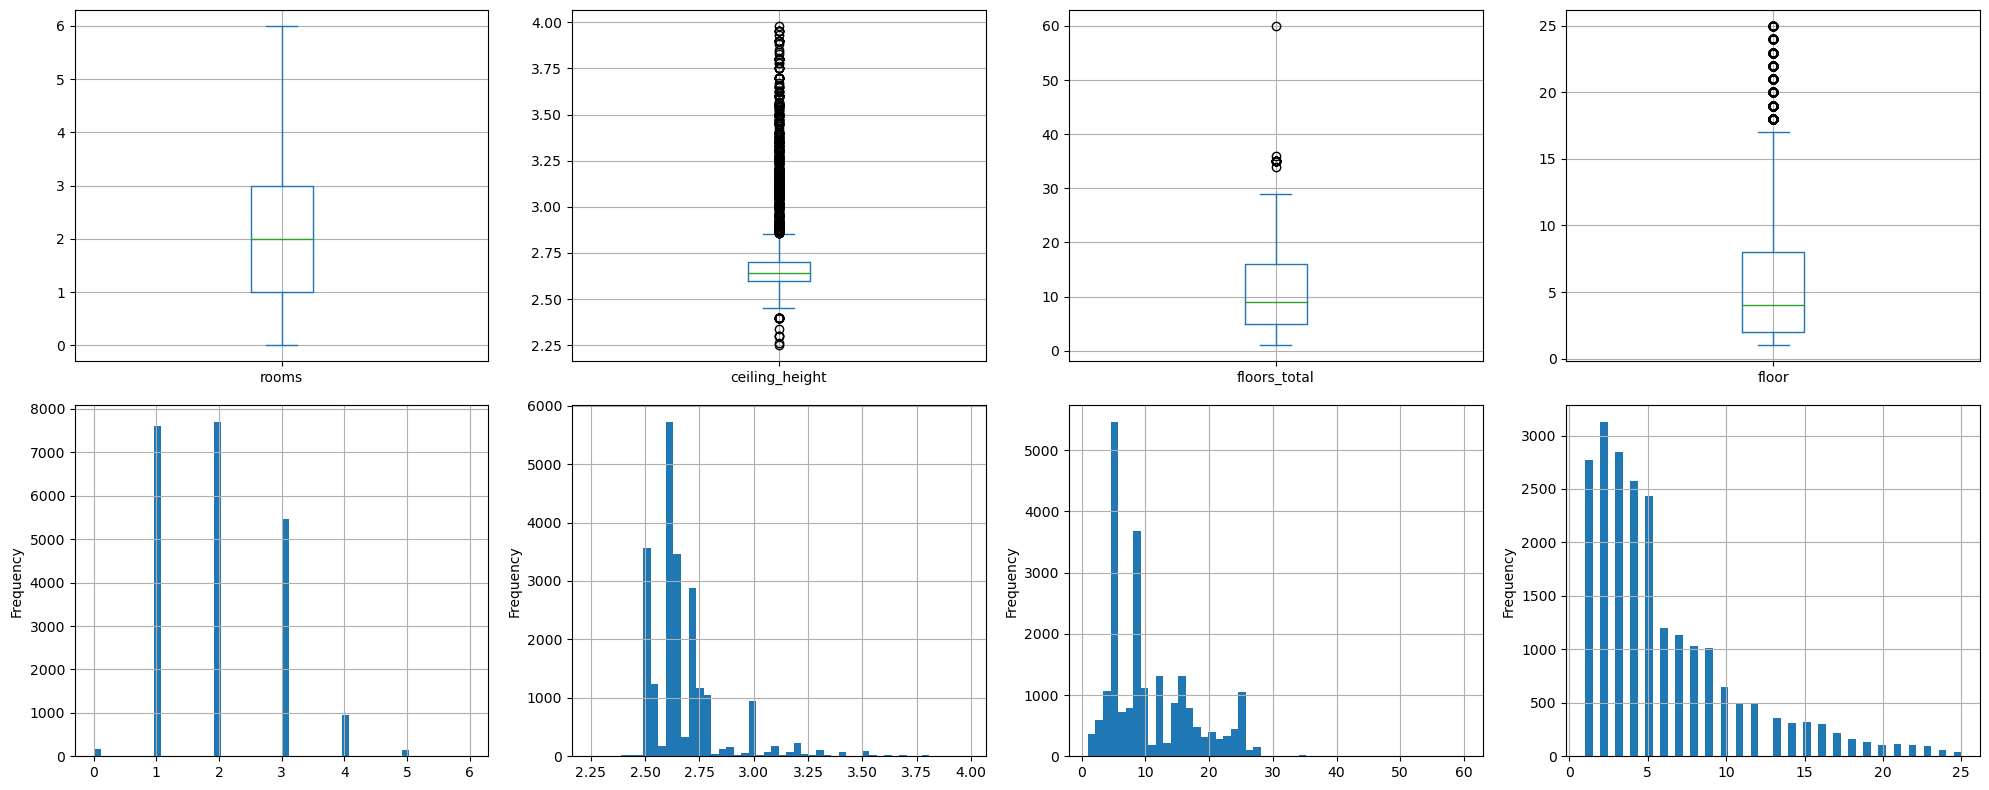

In [67]:
typical_hist(estate, ['rooms', 'ceiling_height', 'floors_total', 'floor'])

По количеству комнат чаще всего выкладывают объявления двухкомнатных квартир, с высотой потолков 2.65, общей этажностью здания в 9 этажей и собственным четвёртым этажом квартиры. При этом, чаще всего дают объявления для здания от 5 до 16 этажей. Можно отметить, что по количеству объявлений на однокомнатные и двухкомнатные приходится примерно одинаковый процент объявлений, но медианным значением всё равно являются двухкомнатные квартиры.

Посмотрим на типы квартир в объявлениях:

In [68]:
display(type_estate(data=estate, col_group='is_apartment', col_count='rooms'))
display(type_estate(data=estate, col_group='studio', col_count='rooms'))
display(type_estate(data=estate, col_group='open_plan', col_count='rooms'))

По типу квартиры на апартаменты приходится 0.2% от всех объявлений, на квартиры-студии - 0.6%, а на квартиры со свободным планом - 0.3%.

In [69]:
display(type_estate(data=estate, col_group='balcony', col_count='rooms'))
display(type_estate(data=estate, col_group='type_floor', col_count='rooms'))

По количеству балконов на рынке преобладают квартиры с отсутствием балконов. Далее идут квартиры с 1 и 2 балконами. Можно отметить, что на квартиры с пятью балконами приходится больший процент объявлений, чем на три и четыре балкона. По типу этажа квартиры можно отметить, что на рынке чаще дают объявления о продаже квартиры на последнем этаже дома, чем на первом.

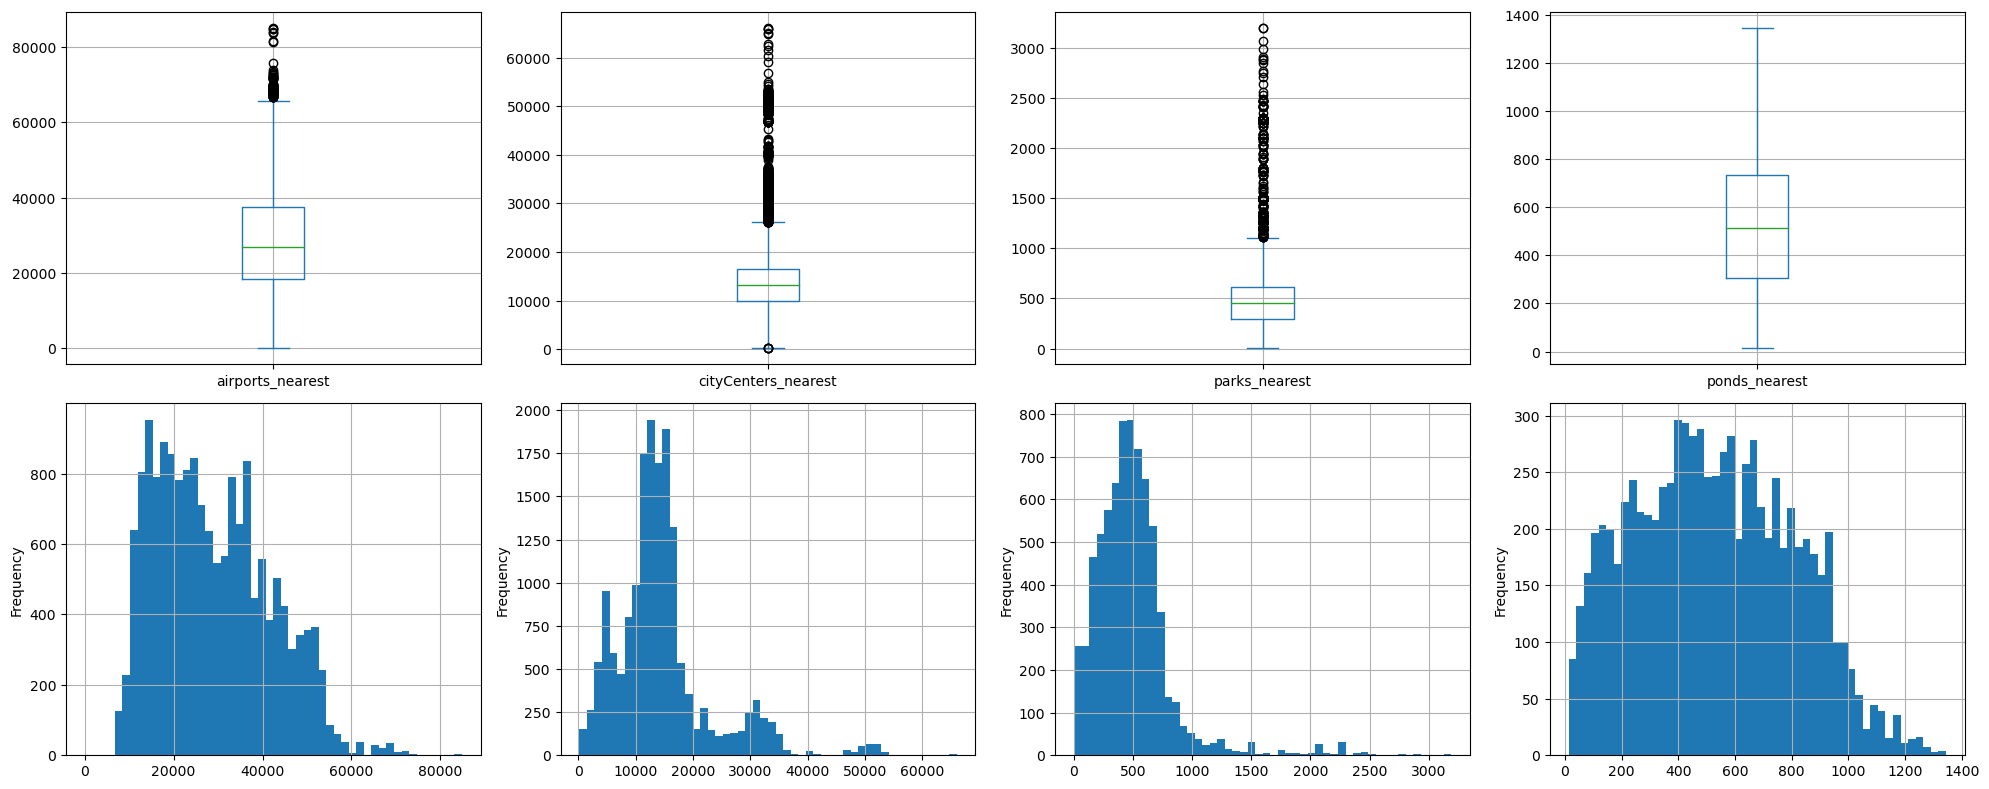

In [70]:
typical_hist(estate, ['airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'ponds_nearest'])

Из графиков расстояний от квартиры до интересных объектов, можно сделать вывод, что в основном выставляют на продажу квартиры, расстоянием до ближайшего аэропорта в 30 км, до центра города - 15 км. с расстоянием до ближайшего парка или водоёма в 500 м. При этом можно отметить, что всё, что дальше 1 км или 1.4 км от квартиры до парка и пруда, соответственно, считается единичными объявлениями.

### Влияние на стоимость квартиры

Необходимо проверить от цего зависит цена на квартиру. Проверим её зависимость от таких параметров, как общая площадь, жилая площадь, площадь кухни, количество комнат, этаж квартиры и дата размещения объявления.

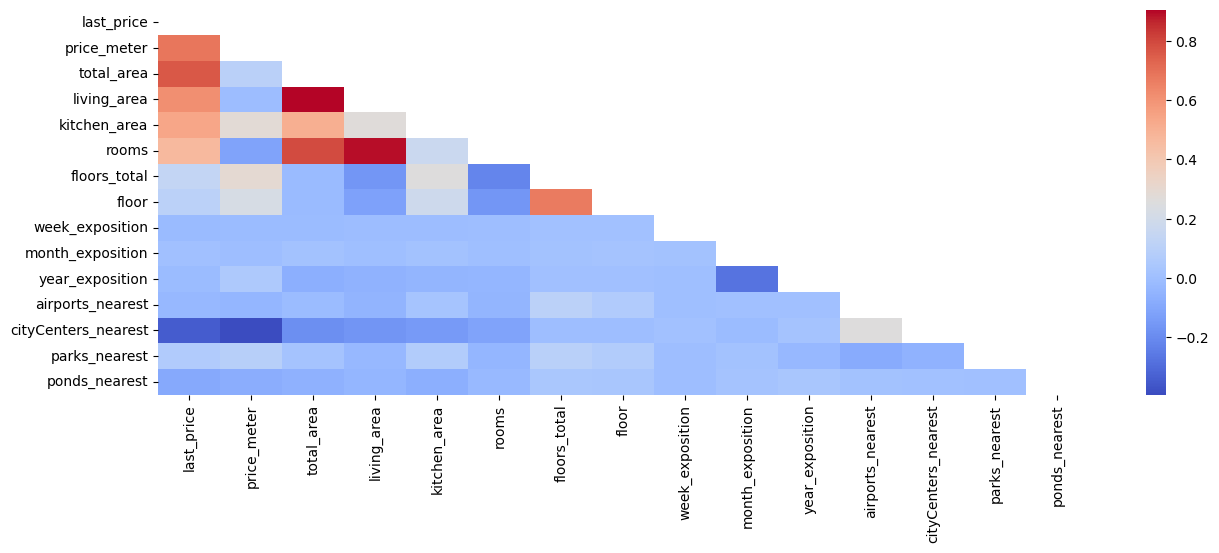

In [71]:
estate_for_price = estate.loc[:,['last_price', 'price_meter', 'total_area', \
                                 'living_area', 'kitchen_area', 'rooms', \
                                 'floors_total', 'floor', \
                                 'week_exposition', 'month_exposition', 'year_exposition',\
                                 'airports_nearest', 'cityCenters_nearest',
                                 'parks_nearest', 'ponds_nearest']]

plt.subplots(figsize=(15, 5))
mask = np.zeros_like(estate_for_price.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(estate_for_price.corr(), mask=mask, cmap=cmap_table);

Из таблицы корреляции видно, что между датой размещения объявления и ценой зависимости нет. Зато площади квартиры имеют большое влияние на цену квартиры, при этом жилая площадь, площадь кухни и количество комнат имеют чуть менее заметное влияние, чем общая площадь.

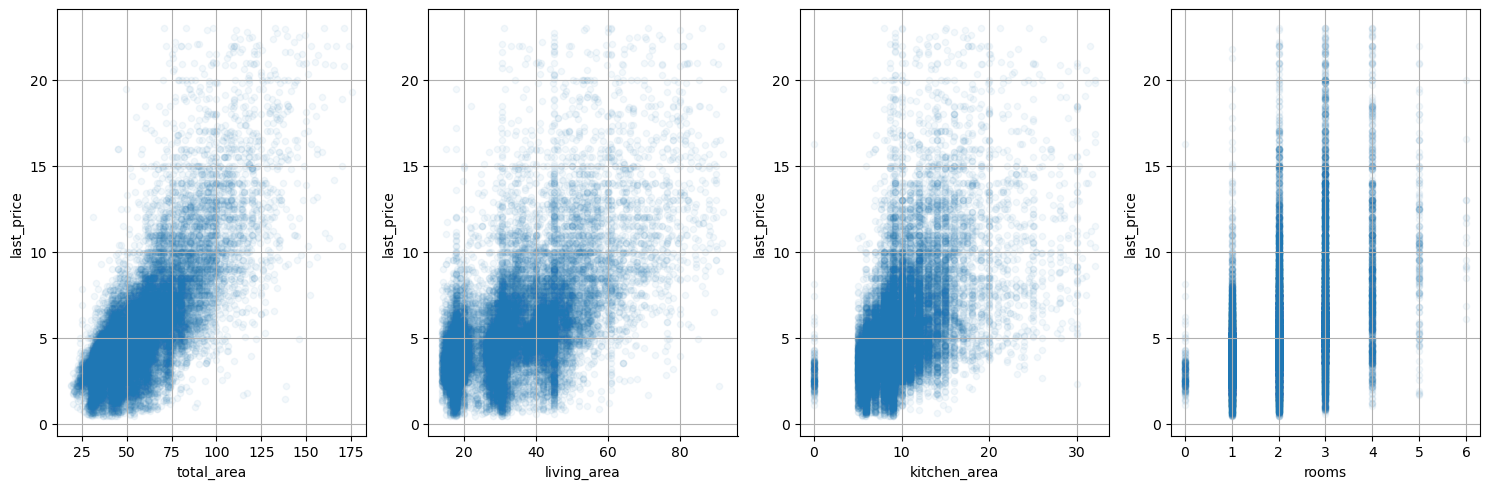

In [72]:
fig = plt.figure()
total_axes = 4 # общее количество графиков
subplt = 1 # номер начального axes

for col in ['total_area', 'living_area', 'kitchen_area', 'rooms']:
    ax = fig.add_subplot(1, total_axes, subplt)
    estate.plot(x=col, 
                y='last_price',
                kind='scatter',
                grid=True,
                alpha=0.05,
                figsize=(15, 5),
                ax=ax) 
    subplt += 1

plt.tight_layout()
plt.show()

Из графика зависимости цены квартиры от общей площади можно увидеть, что основная масса объявлений сосредоточена от 2 до 7 млн рублей за площадь от 30 до 75 м². При этом с увеличением общей площади растёт и цена за квартиру.

На графике зависимости цены квартиры от жилой площади также виден рост с цены с ростом площади, но можно отметить три характерных пятна: в области до 20 м², в окрестности 30 м² и от 40 до 45 м². При этом цены между первыми пятнами не сильно разнятся: в пределах от 1 млн до 6 млн.

На графике зависимости цены от площади кухни видно, что в целом выставляются квартиры с кухней от 5 до 15 м² за цену в пределах от 1 млн до 8 млн. При этом отдельной группой выделяются квартиры-студии от 2 до 4 млн. В целом, данная зависимость также имеет тенденцию к росту цены за квартиру с увеличением доступной площади кухни.

На графике зависимости цены от количества комнат можно отметить, что на квартиры с 5 и 6 комнатами поступает не так много предложений на рынке недвижимости. Основными популряными категориями являются квартиры от 1 до 3 комнат. При этом видно, что с увеличением комнат растёт и цена на квартиру.

Рассмотрим зависимость цены за квартиру от количества комнат.

In [73]:
price_estate(data=estate, col_group='rooms', col_count='last_price')

С ростом количества комнат пропорционально растёт и средняя цена за квартиру. Можно отметить, что так как квартир с 6 комнатами в 10 раз меньше, чем с пятью комнатами, то разница в реальной цене на такие квартиры может быть чуть больше, чем в таблице.

In [74]:
price_estate(data=estate, col_group='type_floor', col_count='last_price')

Дешевле всего квартиры на первом этаже, а на последнем дешевле, чем с любого другого этажа. По количеству объявлений первый этаж так же уступает последнему. Это может быть связано с опасностью быть обворованными на первом этаже, неудобстве держать на окнах решётки и наличия близости подвала.

In [75]:
price_estate(data=estate, col_group='year_exposition', col_count='last_price')

По таблице корреляции между ценой за квартиру и годом объявления была слабая связь. Но, если посмотреть на медианную цену по годам, то можно отметить, что с 2016 по 2018 медианная цена за квартиру не сильно изменилась, но в 2019 немного подросла. Максимум цены за 2014 год объясняется тем, что объявления были только за последние два месяца в году.

In [76]:
df = estate.query('year_exposition != 2014').groupby(['month_exposition','year_exposition'], as_index=False)\
                    [['last_price']].median()
fig = px_plot(data=df, col_group='month_exposition', col_value='last_price', col_color='year_exposition')
fig.update_layout(title='Медианная стоимость в зависимости от месяца публикации',
                  xaxis_title='Месяц объявления',
                  yaxis_title='Медианная стоимость',
                  legend_title='Год')
fig.show()

Медианная стоимость сильно менялась только для 2015 года, для всех остальных годов наблюдается более-менее стабильность по месяцам.

### Цена за 1 м²

Посмотрим на распределение для цены за 1 м².

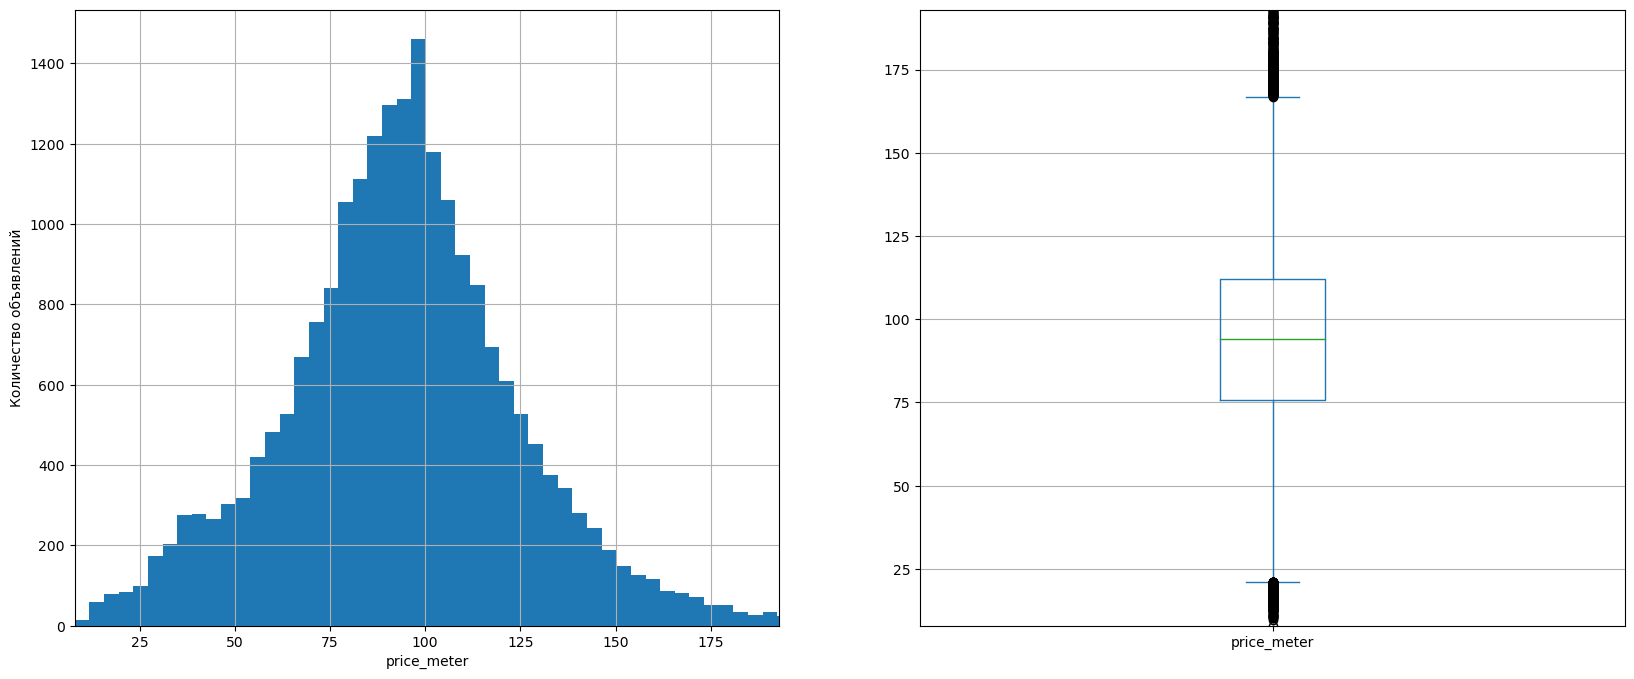

In [77]:
first_hist(data=estate, column='price_meter', h_bins=100)

In [78]:
print('95 и 99 перцентиль для цены квартиры за 1 м²: ', 
      "{0:.1f}".format(np.percentile(estate['price_meter'], 95)), ', '
      "{0:.1f}".format(np.percentile(estate['price_meter'], 99)))

95 и 99 перцентиль для цены квартиры за 1 м²:  149.3 , 193.0


Медианное значение цены за 1 м² находится в области 90 тыс рублей, а всё, что выше 170 тыс или ниже 25 тыс считается выбросами. 99 перцентиль равняется 193 тыс, а 95 - 149. По гистограмме видно, что основное количество объявлений приходится на квартиры ценой за 1 м² до 175 тыс. Причём, максимум приходится на около медианное значение в 100 тыс.

Стоимость метража квартиры необходимо смотреть в совокупности с местом нахождения квартиры. Так как цена за 1 м² в крупном населённом пункте и в посёлке будет отличаться.

### Средняя цена 1 м² для населённых пунктов

Посмотрим на среднюю цену за 1 м² для населённых пунктов по количеству объявлений.

In [79]:
location_price = estate.groupby(by=['locality_name'], as_index=False)\
                       .agg(total_flat = ('last_price', 'count'),
                            median_price = ('last_price', 'median'),
                            median_price_meter = ('price_meter', 'median'))\
                       .sort_values(by='total_flat', ascending=False)\
                       .head(10)\
                       .reset_index(drop=True)
location_price.style.format({'median_price': '{:.1f}', 
                             'median_price_meter': '{:.1f}'})\
              .background_gradient(cmap_table2)

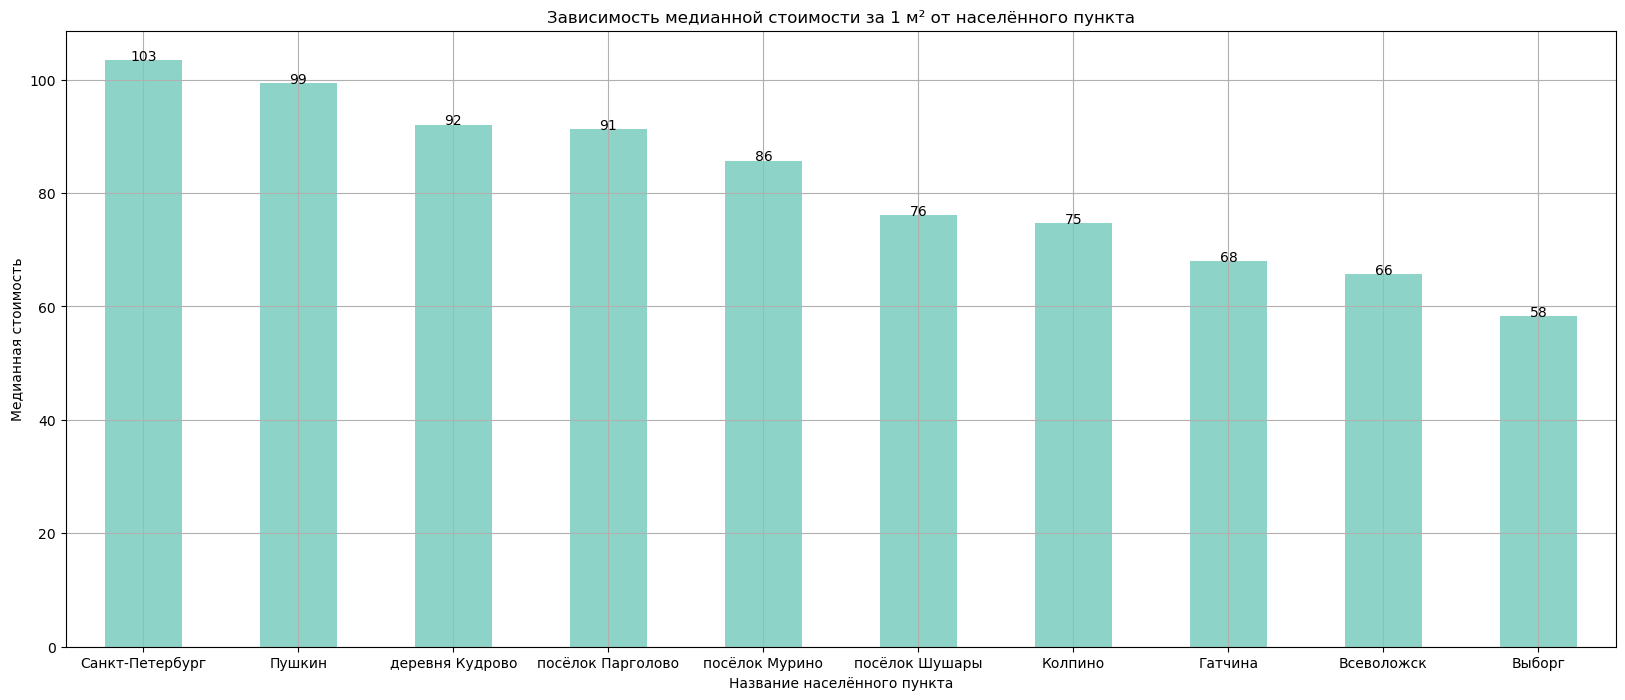

In [80]:
df = location_price.loc[:, ['locality_name', 'median_price_meter']]\
                   .sort_values(by='median_price_meter', ascending=False).reset_index(drop=True)
fig = bar_plot(data=df, col_group='locality_name')
plt.xticks(rotation=0)
addlabels(x=df['locality_name'], y=df['median_price_meter'])
plt.xlabel('Название населённого пункта')
plt.ylabel('Медианная стоимость')
plt.title('Зависимость медианной стоимости за 1 м² от населённого пункта')
plt.show();

Больше всего объявлений приходится на Санкт-Петербург, остальной топ-9 населённых пунктов по количеству объявлений приходится на достаточно крупные административные центры Ленинградской области (Выборг, Гатчина, Пушкин, Колпино). На первое место по средней цене за 1 м² попал СпБ с ценой в 103.5 тыс. На последнем месте находится Выборг с ценой в 58.3 тыс за 1 м². При этом можно отметить, что по количеству объявлений населённые пункты сильно разнятся. Так, в Питере объявлений больше 14.5 тыс, а для Выборга всего 227 штук за все 6 лет.

Посмотрим, как менялась цена в зависимости от года публикации.

In [81]:
df = estate.groupby(['locality_name','year_exposition'], as_index=False)\
                    [['price_meter']].median()
top_location_list = location_price['locality_name'].tolist()
fig = px_plot(data=df.query('locality_name in @top_location_list'), 
              col_group='year_exposition', col_value='price_meter', col_color='locality_name')
fig.update_layout(title='Медианная стоимость 1 м² в зависимости от года публикации',
                  xaxis_title='Год',
                  yaxis_title='Медианная стоимость',
                  legend_title='Топ-10')
fig.show()

Можно отметить, что для большинства населённых пунктов произошло увеличение цены за 1 м² за 2015-2019 года.

### Изучение продаваемости квартиры

Посмотрим на распределение времени продажи квартиры.

In [82]:
estate['days_exposition'].describe()

count    19216.000000
mean       176.836855
std        215.852542
min          1.000000
25%         44.000000
50%         93.000000
75%        224.000000
max       1580.000000
Name: days_exposition, dtype: float64

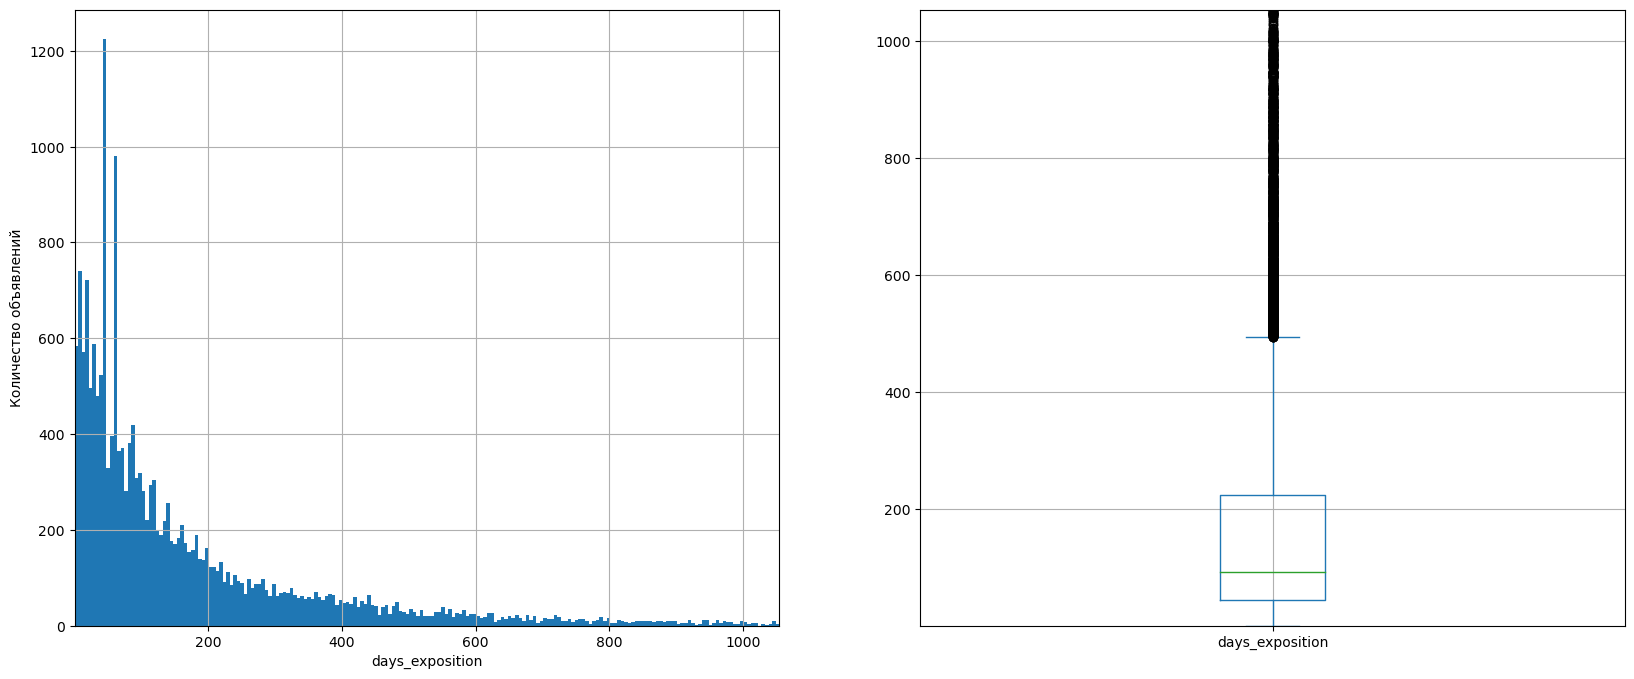

In [83]:
first_hist(data=estate, column='days_exposition', h_bins=300)

In [84]:
print('95 и 99 перцентиль для времени продажи квартиры: ', 
      "{0:.1f}".format(np.percentile(estate[~estate['days_exposition'].isna()]['days_exposition'], 95)), ', '
      "{0:.1f}".format(np.percentile(estate[~estate['days_exposition'].isna()]['days_exposition'], 99)))

95 и 99 перцентиль для времени продажи квартиры:  629.0 , 1054.0


Минимальное значение соответствует одному дню, а максимально долгая продажа произошла спустя 4 года от размещения объявления. Это значение меньше, чем общее количество годов, за которые рассмотрены объявления. Медианное значение соответствует 93 дням от дня публикации, а среднее - 176 дней. При этом стандартное отклонение достаточно большое: 215 дней, что является большим значением, чем медиана.

Основная масса объявлений находится по длительности продажи от 44 до 224 дней. Всё, что меньше 44 дней (1.5 месяца) можно считать быстрыми продажами, всё, что больше 224 дней - долгими. От 500 дней (1.5 года) продажи можно считать аномально долгими.

### Зависимость цены квартиры от расстояния от центра города

Посмотрим на зависимость цены квартиры при удалении от центра города. Возьмём объявления для Санкт-Петербурга.

In [85]:
estate_spb = estate[(estate['locality_name'] =='Санкт-Петербург') \
                    & ~(estate['cityCenters_nearest_km'].isna())]\
                   .groupby(by=['cityCenters_nearest_km'], as_index=False)\
                   .agg(total_flat = ('last_price', 'count'),
                        median_price = ('last_price', 'median'),
                        median_price_meter = ('price_meter', 'median'))
estate_spb['cityCenters_nearest_km'] = estate_spb['cityCenters_nearest_km']\
                                                 .astype('int64', errors='ignore')
estate_spb.style.format({'median_price': '{:.1f}', 
                         'median_price_meter': '{:.1f}'})\
                .background_gradient(cmap_table2)

На расстояния с 11 по 17 км от центра города приходится максимум объявлений, а с 23 по 29 км - объявлений крайне мало. Поэтому для 23 км можно увидеть резкое увеличение медианной цены за квартиру, хотя это объясняется недостаточным количеством квартир для этой области.

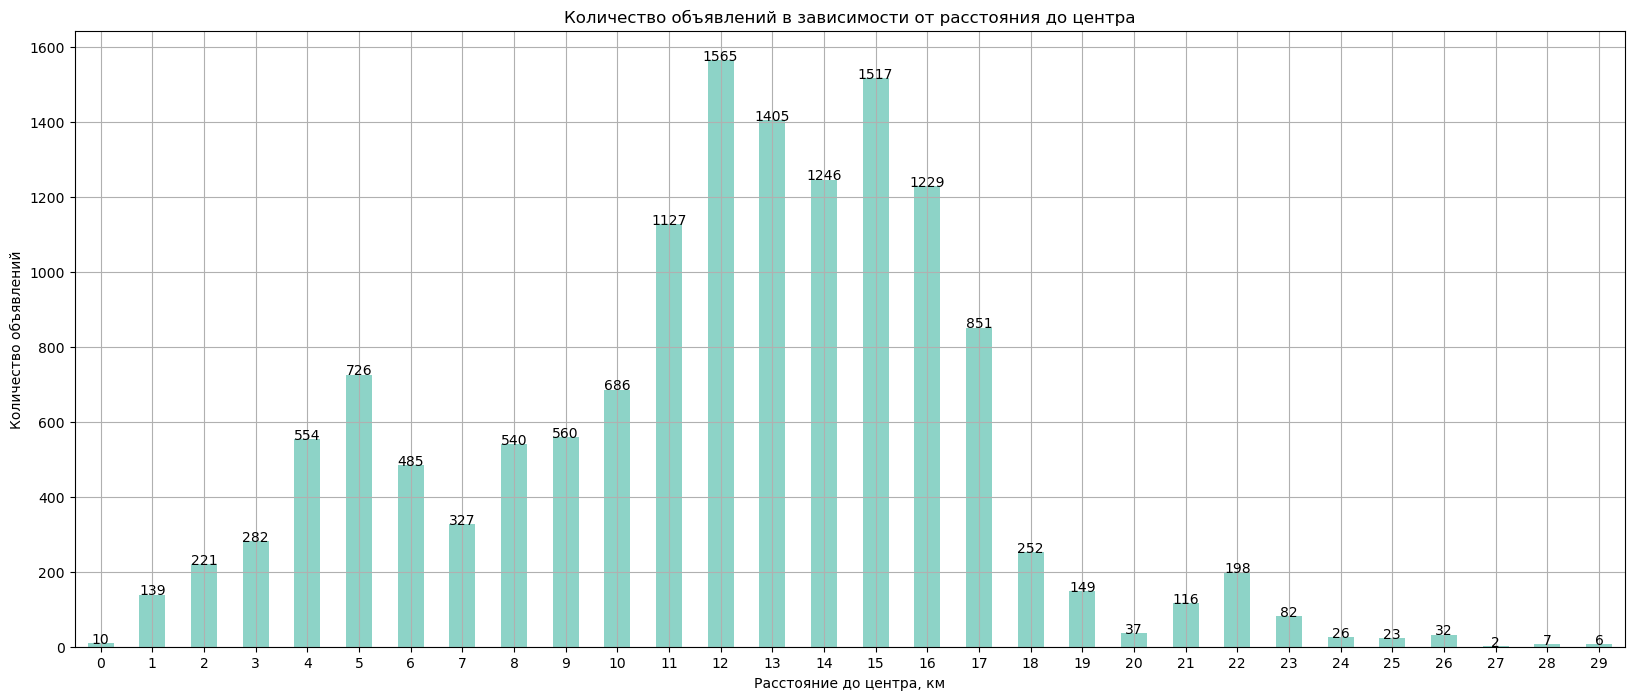

In [86]:
df = estate_spb.loc[:, ['cityCenters_nearest_km', 'total_flat']]
fig = bar_plot(data=df, col_group='cityCenters_nearest_km')
plt.xticks(rotation=0)
addlabels(x=df['cityCenters_nearest_km'], y=df['total_flat'])
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Количество объявлений')
plt.title('Количество объявлений в зависимости от расстояния до центра')
plt.show();

Максимум объявлений о продаже квартир приходится на область от 11 до 17 км от центра города. После 17 км на продажу выставляется мало квартир.

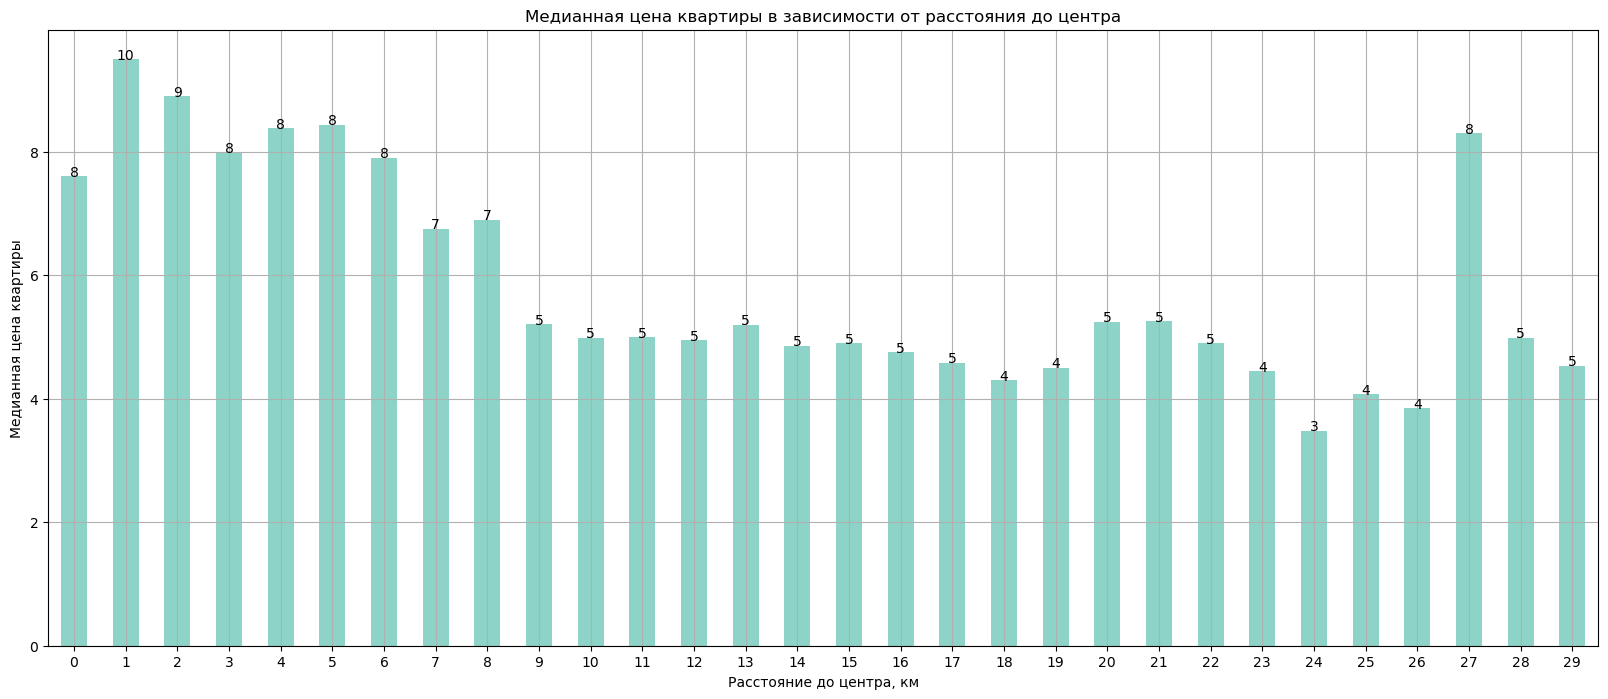

In [87]:
df = estate_spb.loc[:, ['cityCenters_nearest_km', 'median_price']]
fig = bar_plot(data=df, col_group='cityCenters_nearest_km')
plt.xticks(rotation=0)
addlabels(x=df['cityCenters_nearest_km'], y=df['median_price'])
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Медианная цена квартиры')
plt.title('Медианная цена квартиры в зависимости от расстояния до центра')
plt.show();

Медианная цена, в целом, имеет тренд к снижению значения при удалении от центра города. Единичные всплески повышенной цены можно объяснить тем, что присутствует недостаточное количество объявлений для этой области, что не может являться релевантным значением.

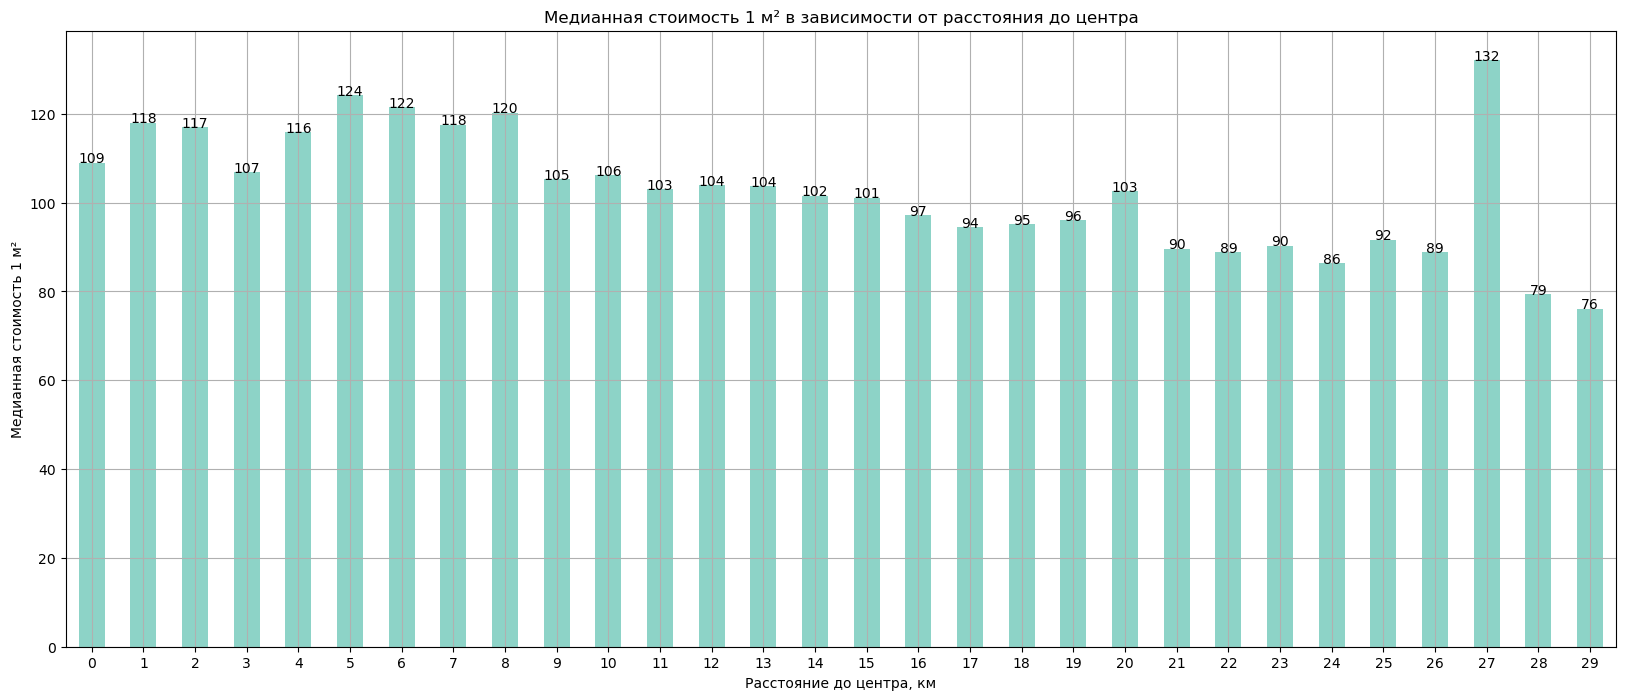

In [88]:
df = estate_spb.loc[:, ['cityCenters_nearest_km', 'median_price_meter']]
fig = bar_plot(data=df, col_group='cityCenters_nearest_km')
plt.xticks(rotation=0)
addlabels(x=df['cityCenters_nearest_km'], y=df['median_price_meter'])
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Медианная стоимость 1 м²')
plt.title('Медианная стоимость 1 м² в зависимости от расстояния до центра')
plt.show();

Для медианной цены за 1 м² наблюдается тот же тренд к снижению при удалении от центра. При этом можно отметить, что с 9 по 15 км от центра цена за 1 м² находится практически на одном уровне. 

Помимо удаления от центра города на стоимость квартиры может влиять год постройки дома, наличие инфрастуктуры рядом: наличие метро и остановок общественного транспорта, школы, детские сады, торговые центры, парки. Всё это может повлиять на общуют цену квартиры и стоимость за 1 м².

### Промежуточные выводы:

- Объявления представлены за 6 лет с 2014 по 2019 включительно. В 2019 году представлены данные только 5 первых месяцев, а в 2014 - за 2 последних.
- Максимальное количество объявлений пришлось на 2017 и 2018 года.
- В разные года количество объявлений в зависимости от месяца объявления была несколько разной.
- В общем случае, в январе, мае и декабре наблюдается просадка по количеству объявлений, а с июня по октябрь - небольшой рост.
- Для каждого из годов размещения наблюдается общая тенденция: уменьшение количества объявлений в выходные дни.
- По типу квартиры на апартаменты приходится 0.2% от всех объявлений, на квартиры-студии - 0.6%, а на квартиры со свободным планом - 0.3%.
- Из первого и последнего этажа чаще выставляют квартиры с последнего этажа, а реже - с первого. По цене квартиры на первом этаже дешевле последнего этажа.
- На цену квартиры наибольшее влияние имеет её площадь.
- Медианная стоимость квартир немного подрасла с 2015 по 2019 года.
- Больше всего объявлений приходится на Санкт-Петербург, остальной топ-9 населённых пунктов по количеству объявлений приходится на достаточно крупные административные центры Ленинградской области.
- На первом месте по средней цене за 1 м² находится СпБ с ценой в 103.5 тыс. 
- На последнем месте по средней цене за 1 м² находится Выборг с ценой в 58.3 тыс. 
- Для большинства населённых пунктов произошло увеличение цены за 1 м² за 2015-2019 года.
- Основная масса объявлений по длительности продажи находится от 44 до 224 дней. 
- Продажи до 1.5 месяцев можно считать быстрыми, а дольше 1.5 лет - аномально долгими.
- На 11 по 17 км от центра города приходится максимум объявлений, а с 23 по 29 км - объявлений крайне мало. 
- Медианная цена квартиры имеет тренд к снижению значения при удалении от центра города.
- Для медианной цены за 1 м² присутствует тренд к снижению при удалении от центра.
- С 9 по 15 км от центра цена квартиры за 1 м² находится практически на одном уровне. 

По объявлениям чаще всего квартиры имеют такие параметры:
- Цена в 4 млн
- Общая площадь 50 м²
- Жилая площадь 30 м²
- Площадь кухни 8 м²
- Две комнаты
- Высота потолков 2.65 м
- Отсутствие балконов
- Общая этажность здания 9 этажей
- Этаж квартиры: четвёртый
- Расстояние до ближайшего аэропорта - 30 км
- Расстояние до  центра города - 15 км
- Расстояние до ближайшего парка или водоёма - 500 м

## Итоги исследования

Было проведено исследование по теме зависимостей на стоимость квартиры в Ленинградской области. Предоставлены данные с ноября 2014 года по май 2019 года. Необходимо было проанализировать данные, выявить закономерности и аномалии.

Перед анализом, данные были подготовлены для корректной работы:
- В таблице находилось 22 столбца и 23699 записей с данными о продаже квартир.
- В таблице не было явных дубликатов.
- В 14 столбцах были пропуски занчений, причём в четырёх столбцах они занимали более 40%.
- Были удалены аномальные значения из пяти столбцов.
- Аномальными считались значения снизу, которые не согласовались с требованиями в России к квартирам.
- Ограничение сверху было по 99 перцентилю.
- После удаления аномалий, в тех столбцах, где это было возможным, пропуски были заполнены медианными значениями в зависимости от типа квартиры.
- В пяти столбцах пропуски были оставлены, так как восстановить в них значения не предоставляется возможным.
- Удалённые данные составили 6.9% от всех данных в датафрейме.
- Типы данных в с толбцах были приведены к правильным.
- Были удалены неявные дубликаты из столбца с названием населённого пункта. После замены осталось 315 уникальных названий населённых пунктов вместо 360.
- В таблицу были добавлены новые столбцы: с годом, месяцем и неделей размещения объявления, с ценой (тыс рублей) за 1 м², типом этажа квартиры и расстояние до центра в км.
- Данные подготовлены для дальнейшего анализа.

Была проанлизирована информация об объявлениях о продаже квартир. По объявлениям чаще всего квартиры имеют такие параметры:
- Цена в 4 млн
- Общая площадь 50 м²
- Жилая площадь 30 м²
- Площадь кухни 8 м²
- Две комнаты
- Высота потолков 2.65 м
- Отсутствие балконов
- Общая этажность здания: 9 этажей
- Этаж квартиры: четвёртый
- Расстояние до ближайшего аэропорта - 30 км
- Расстояние до  центра города - 15 км
- Расстояние до ближайшего парка или водоёма - 500 м

Были изучены такие показатели квартиры, как: площадь квартиры, количество комнат, тип этажа, дата объявления:
- Объявления представлены за 6 лет с 2014 по 2019 включительно. В 2019 году представлены данные только 5 первых месяцев, а в 2014 - за 2 последних.
- Основная масса объявлений по длительности продажи находится от 44 до 224 дней. 
- Продажи до 1.5 месяцев можно считать быстрыми, а дольше 1.5 лет - аномально долгими.
- Максимальное количество объявлений пришлось на 2017 и 2018 года.
- В разные года количество объявлений в зависимости от месяца объявления была несколько разной.
- В общем случае, в январе, мае и декабре наблюдается просадка по количеству объявлений, а с июня по октябрь - небольшой рост.
- Для каждого из годов размещения наблюдается общая тенденция: уменьшение количества объявлений в выходные дни.
- По типу квартиры на апартаменты приходится 0.2% от всех объявлений, на квартиры-студии - 0.6%, а на квартиры со свободным планом - 0.3%.
- Из первого и последнего этажа чаще выставляют квартиры с последнего этажа, а реже - с первого. 

Было изучено влияние разных параметров на стоимость квартиры и на стоимость 1 м²:
- На цену квартиры наибольшее влияние имеет её площадь и косвенно, тесно связанное с этим показателем количество комнат.
- День размещения объявления, как месяц практически никакого влияния на стоимость не оказывают.
- Медианная стоимость квартир немного подрасла с 2015 по 2019 года.
- По цене квартиры на первом этаже дешевле последнего этажа.
- Больше всего объявлений приходится на Санкт-Петербург, остальной топ-9 населённых пунктов по количеству объявлений приходится на достаточно крупные административные центры Ленинградской области.
- На первом месте по средней цене за 1 м² находится СпБ с ценой в 103.5 тыс. 
- На последнем месте по средней цене за 1 м² находится Выборг с ценой в 58.3 тыс. 
- Для большинства населённых пунктов произошло увеличение цены за 1 м² за 2015-2019 года.

Отдельно были рассмотрены объявления о продаже квартир в СпБ:
- На 11 по 17 км от центра города приходится максимум объявлений, а с 23 по 29 км - объявлений крайне мало. 
- Медианная цена квартиры имеет тренд к снижению значения при удалении от центра города.
- Для медианной цены за 1 м² присутствует тренд к снижению при удалении от центра.
- С 9 по 15 км от центра цена квартиры за 1 м² находится практически на одном уровне. 